In [1]:
import mesa
import math
import numpy as np
from model import Evacuation
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm

c:\Users\User1\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_theme(style = "whitegrid", palette = "Pastel1")

In [3]:
#Evacuation(n=10, width=20, height=10, door_width = 4, seed=10, model_type = "BNE_mixed_SR", p_BNE = 100)

def batch_run(params, iters = 50):

    if __name__ == '__main__':
        results = mesa.batch_run(
            Evacuation,
            parameters=params,
            iterations=iters,
            max_steps=500,
            number_processes=8,
            data_collection_period=-1,
            display_progress=1
        )

    results_df = pd.DataFrame(results)
    ev_times = results_df.groupby("RunId").first().Step
    return ev_times

### Czas ewakuacji dla ustalonego otoczenia i liczby pieszych w zależności od algorytmu

#### box ploty

In [4]:
results_box_bne = batch_run({"n": 1000 , "width": 68, "height": 20, "door_width": 6, "seed": None, "model_type": "BNE_mixed_SR", "p_BNE": 100})

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [02:38<00:00,  3.16s/it]


In [5]:
results_box_rf = batch_run({"n": 1000 , "width": 68, "height": 20, "door_width": 6, "seed": None, "model_type": "BNE_mixed_RF", "p_BNE": 0})

100%|██████████| 50/50 [06:22<00:00,  7.65s/it]


In [6]:
results_box_sr = batch_run({"n": 1000 , "width": 68, "height": 20, "door_width": 6, "seed": None, "model_type": "BNE_mixed_SR", "p_BNE": 0})

100%|██████████| 50/50 [04:16<00:00,  5.13s/it]


In [7]:
box_df = pd.DataFrame(
    {   "model_type": np.repeat(["BNE", "SR", "RF"], 50),
        "exit_time": np.concatenate((results_box_bne.values, results_box_sr.values, results_box_rf.values))
    })
box_df

,model_type,exit_time
0,BNE,102
1,BNE,110
2,BNE,117
3,BNE,98
4,BNE,115
...,...,...
145,RF,116
146,RF,190
147,RF,142
148,RF,204


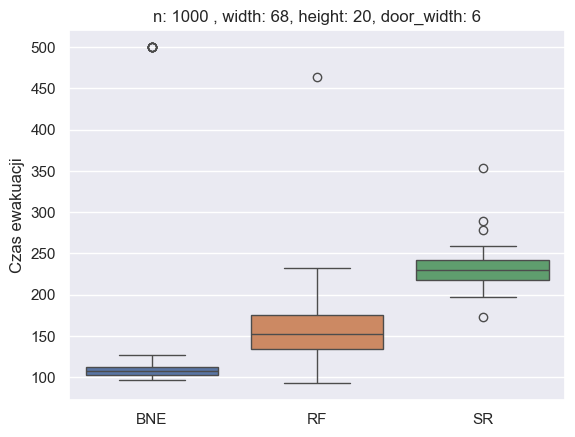

In [20]:
sns.boxplot( np.array([results_box_bne, results_box_rf, results_box_sr]).T)
plt.xticks(np.arange(3), ["BNE", "RF", "SR"])
plt.title("n: 1000 , width: 68, height: 20, door_width: 6")
plt.ylabel("Czas ewakuacji")
plt.show()

#### Przykładowe klatki z różnych metod

In [9]:
import matplotlib.colors as mplc
import matplotlib as mpl
def frames(method):
    
    model_type = method[0]
    p_bne = method[1]

    frames_nums = [0, 20, 40, 60, 80, 100 ]
    model = Evacuation(n = 1000, width = 68, height = 20, door_width = 6, seed = 10, model_type=model_type, p_BNE = p_bne)

    agent_counts = np.zeros((model.grid.width, model.grid.height))
    step_num=0
    while model.running:
        for cell_content, (x, y) in model.grid.coord_iter():
            agent_count = len(cell_content)
            agent_counts[x][y] = agent_count
        model.step()
        if step_num in frames_nums:
            plt.figure(figsize=(model.grid.width, model.grid.height))
            sns.set_style('dark', {"axes.facecolor": "0.95"})
            sns.heatmap(agent_counts.T, cmap="mako_r", annot=True, cbar=True, norm = mplc.LogNorm(vmin=1, vmax=25))
            plt.gca().invert_yaxis()
            plt.title(f"{model_type} step {step_num}")
            plt.show()
        step_num +=1

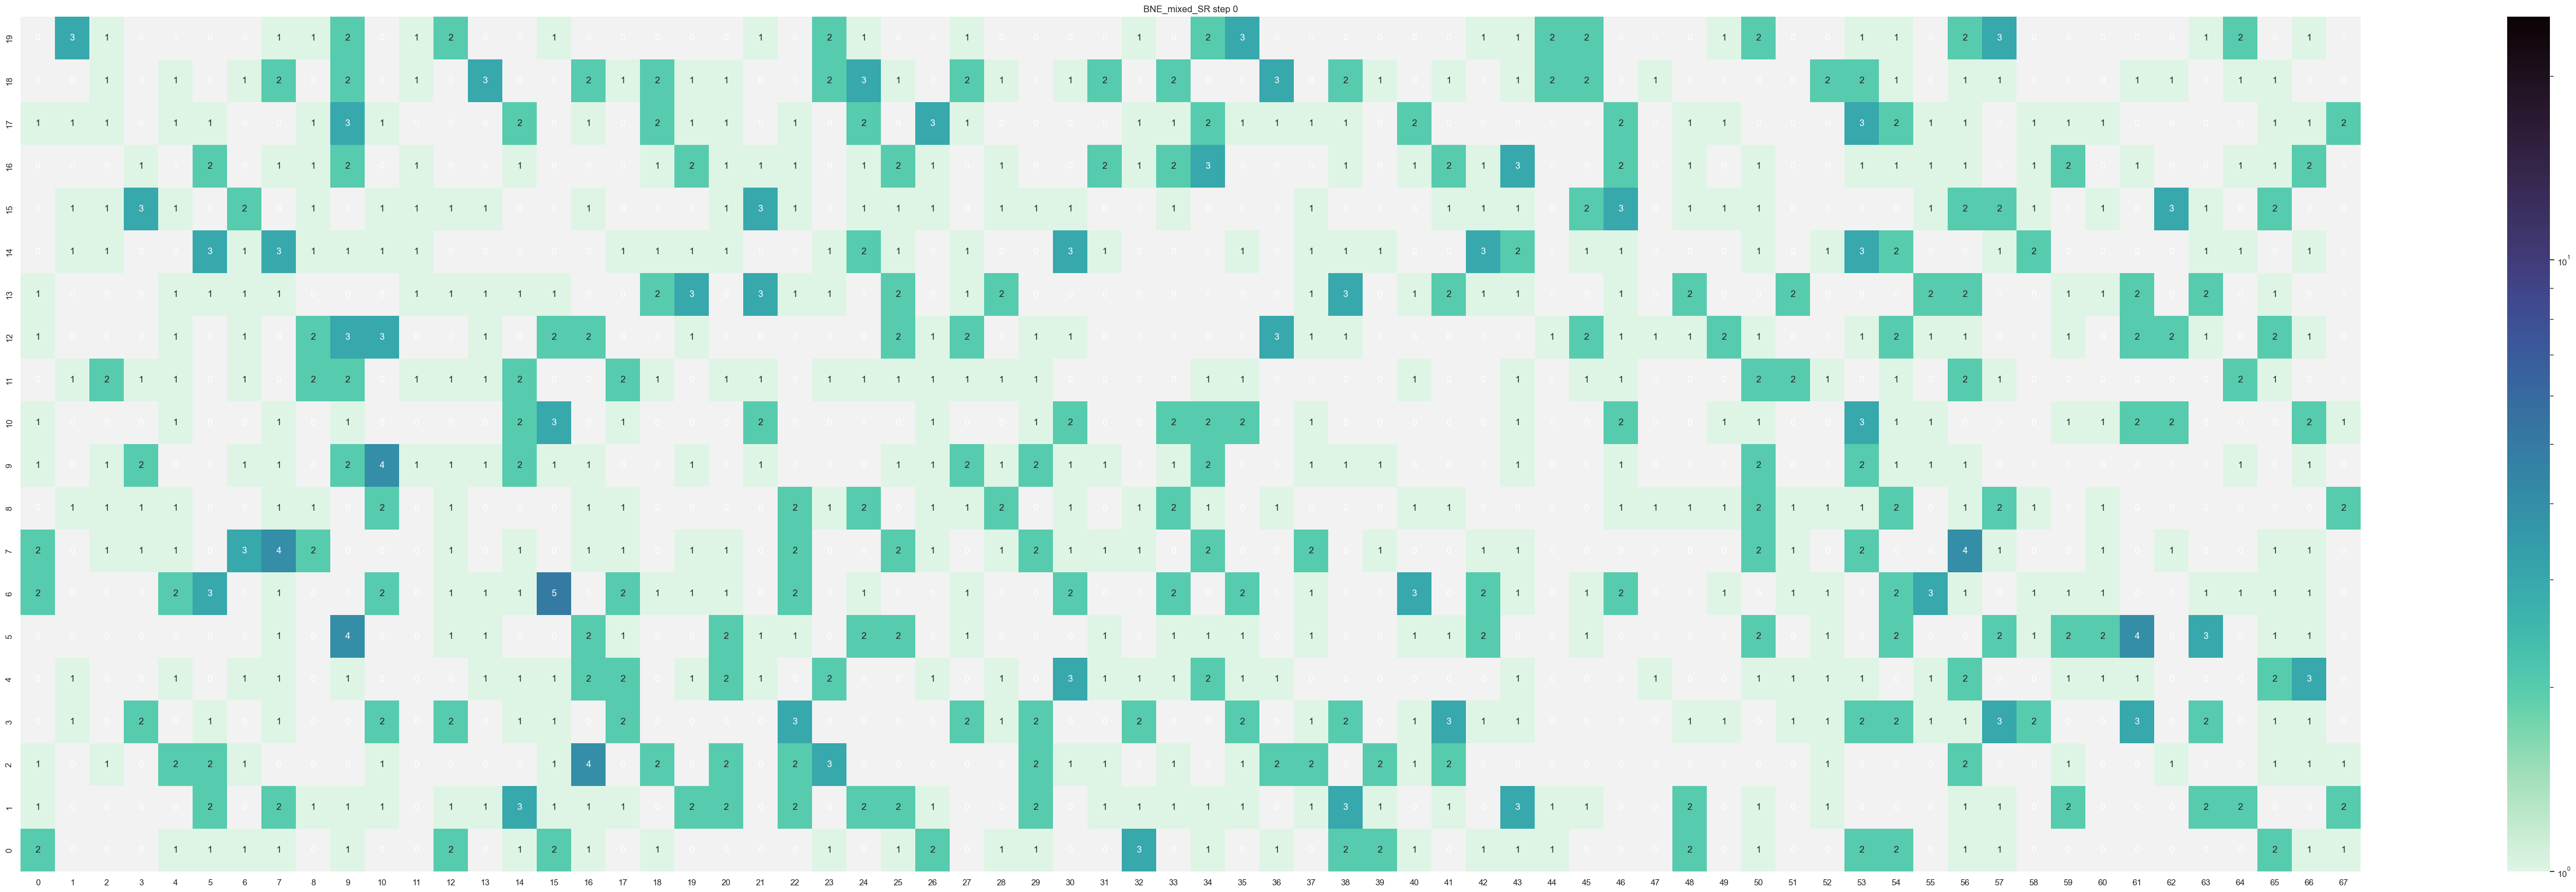

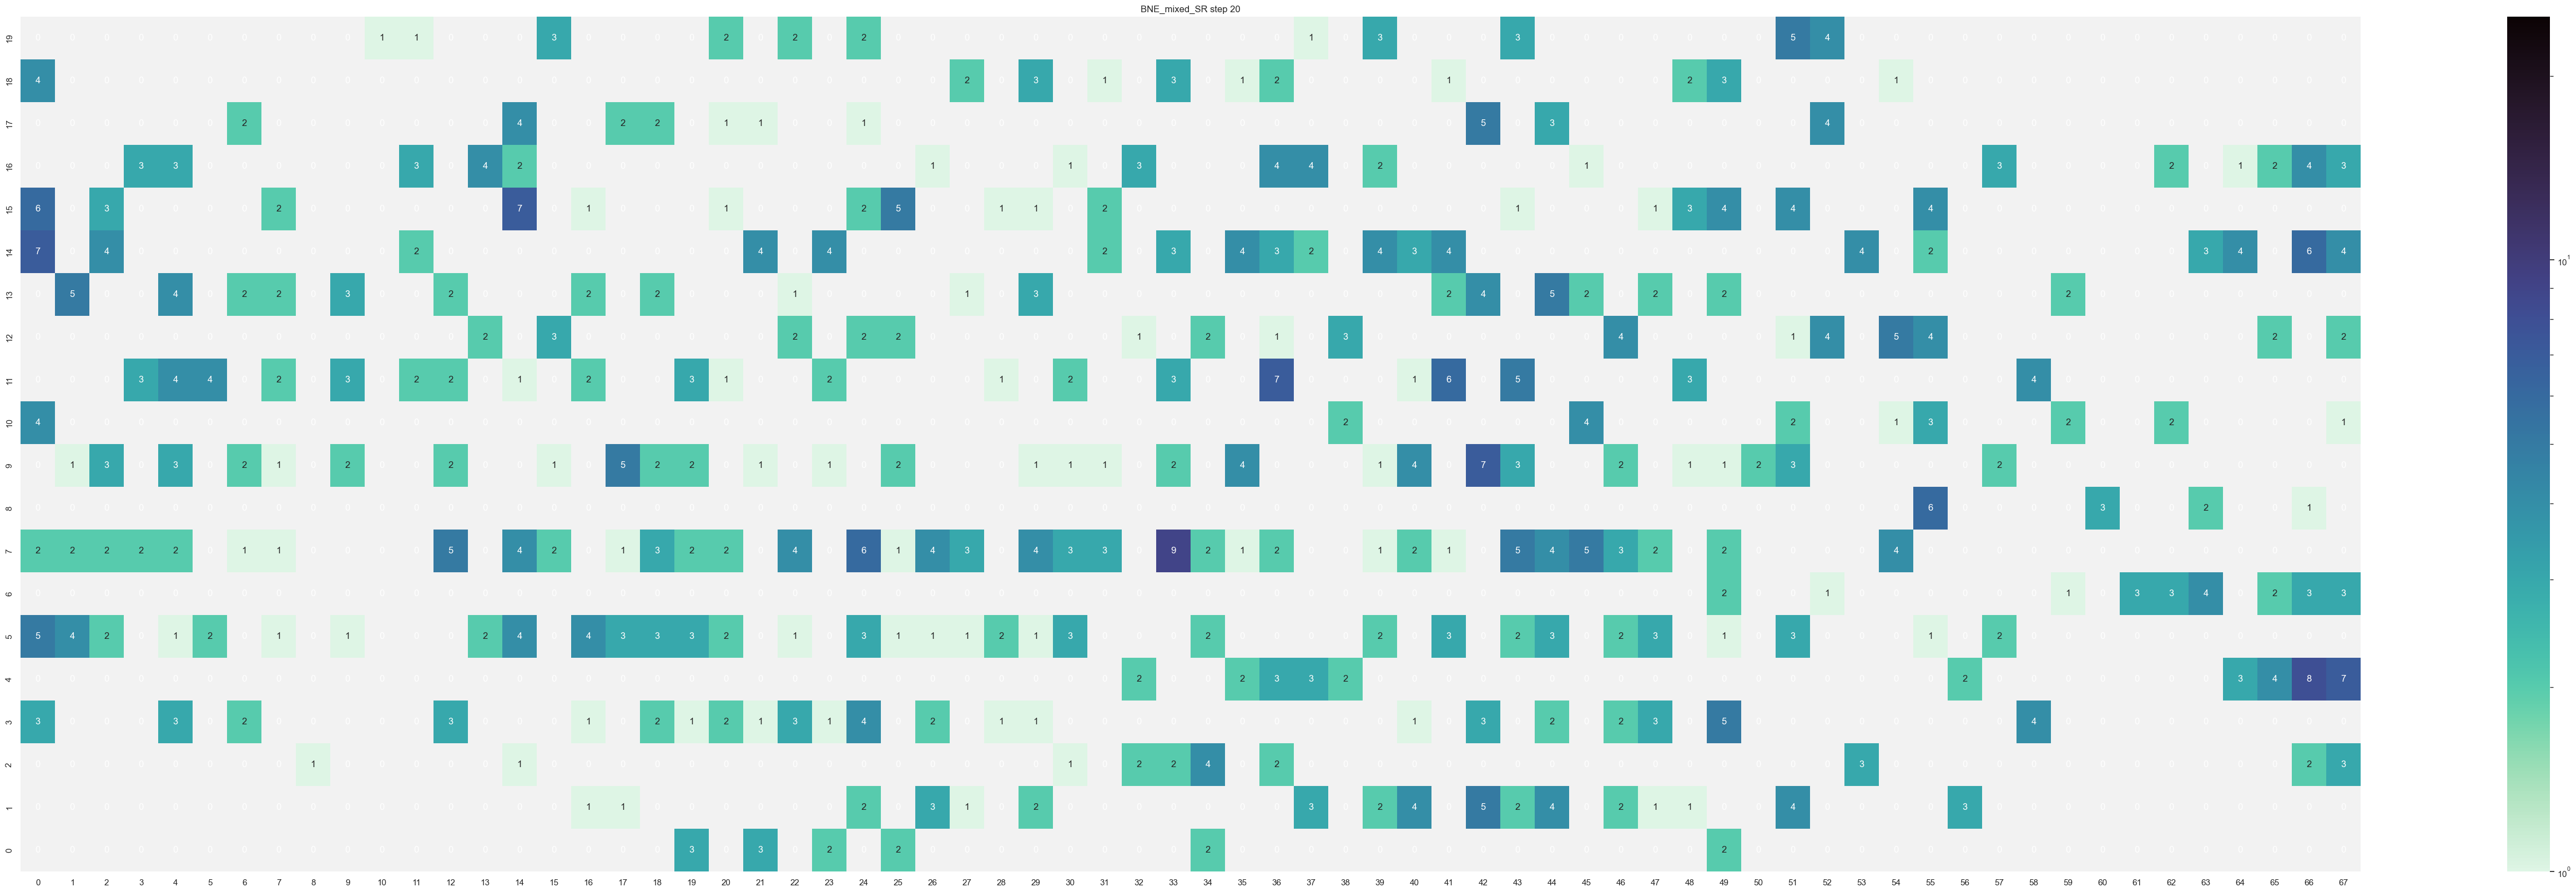

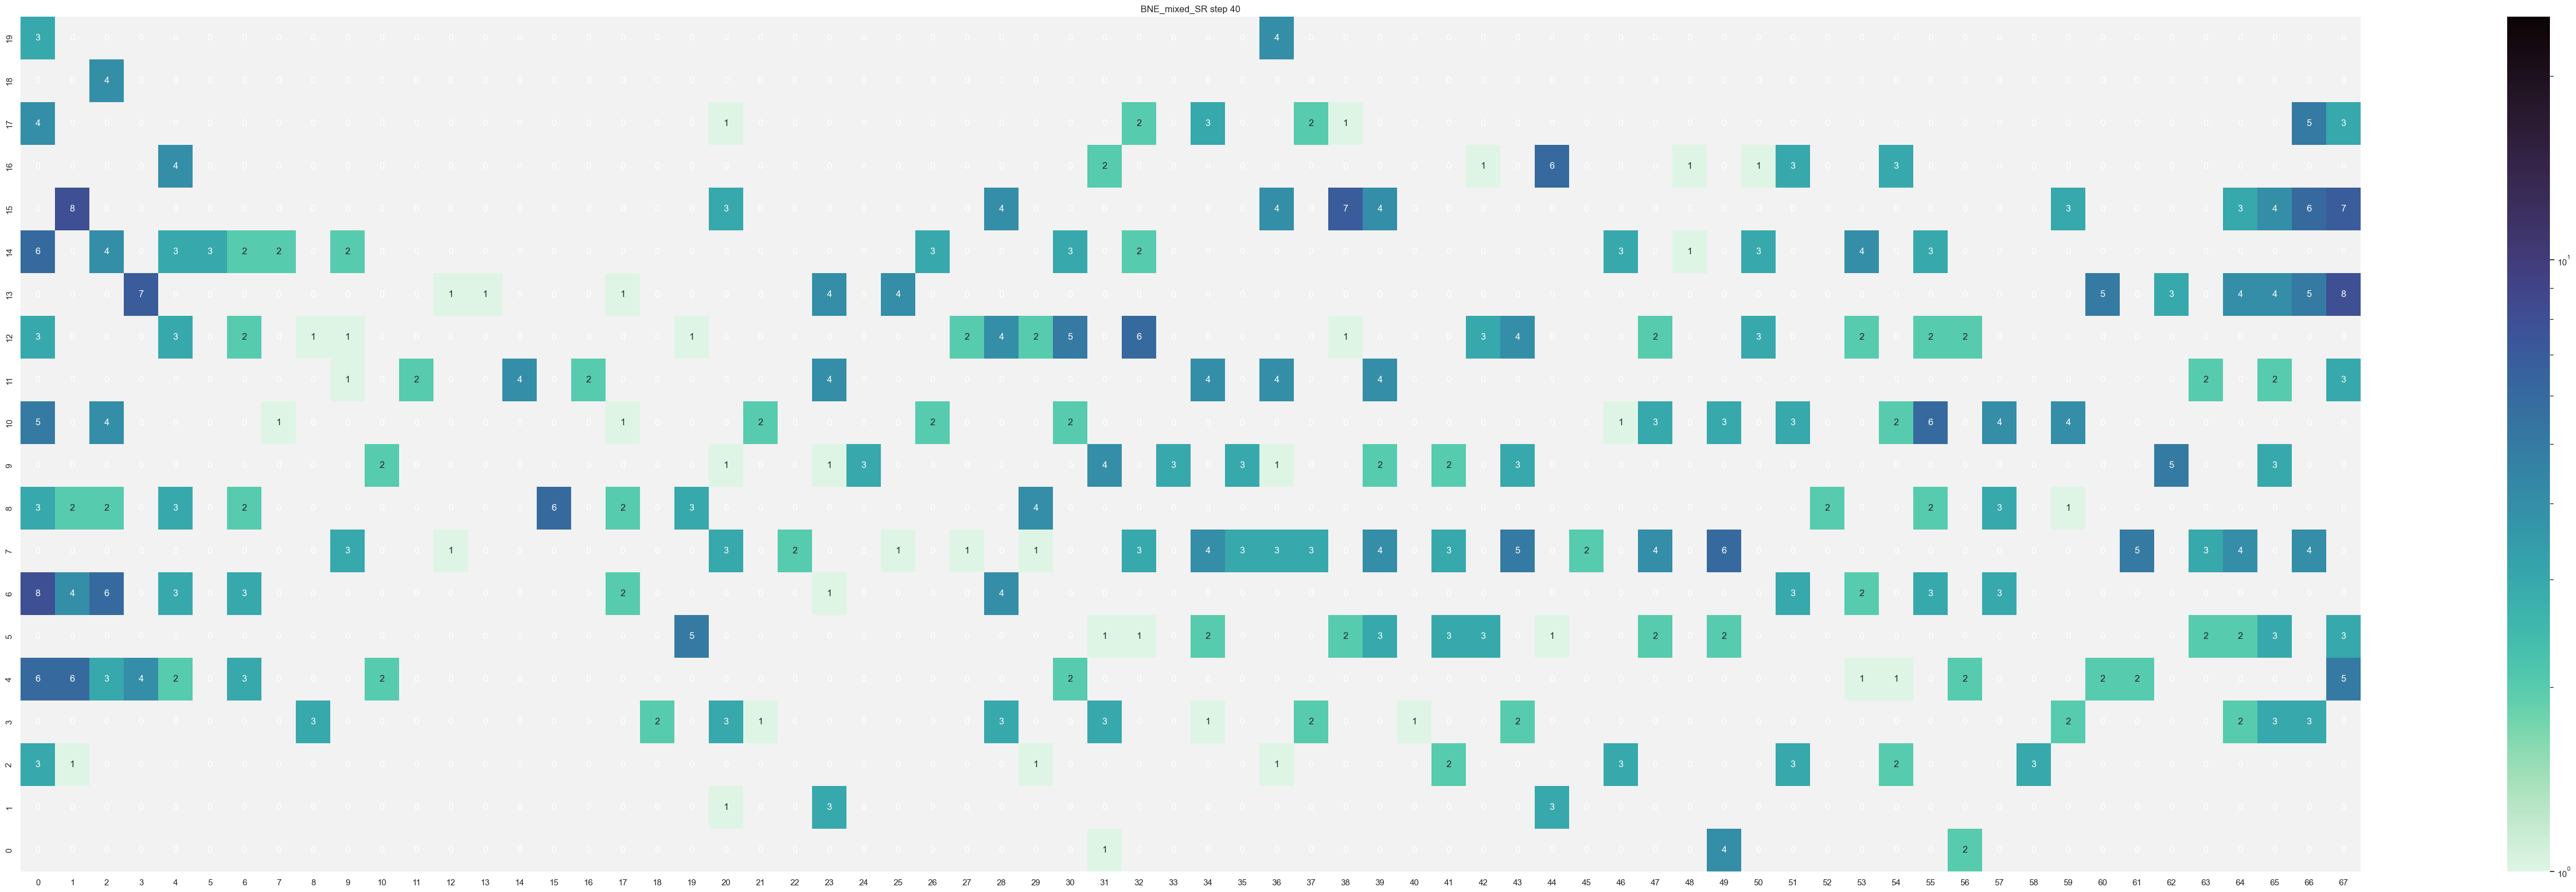

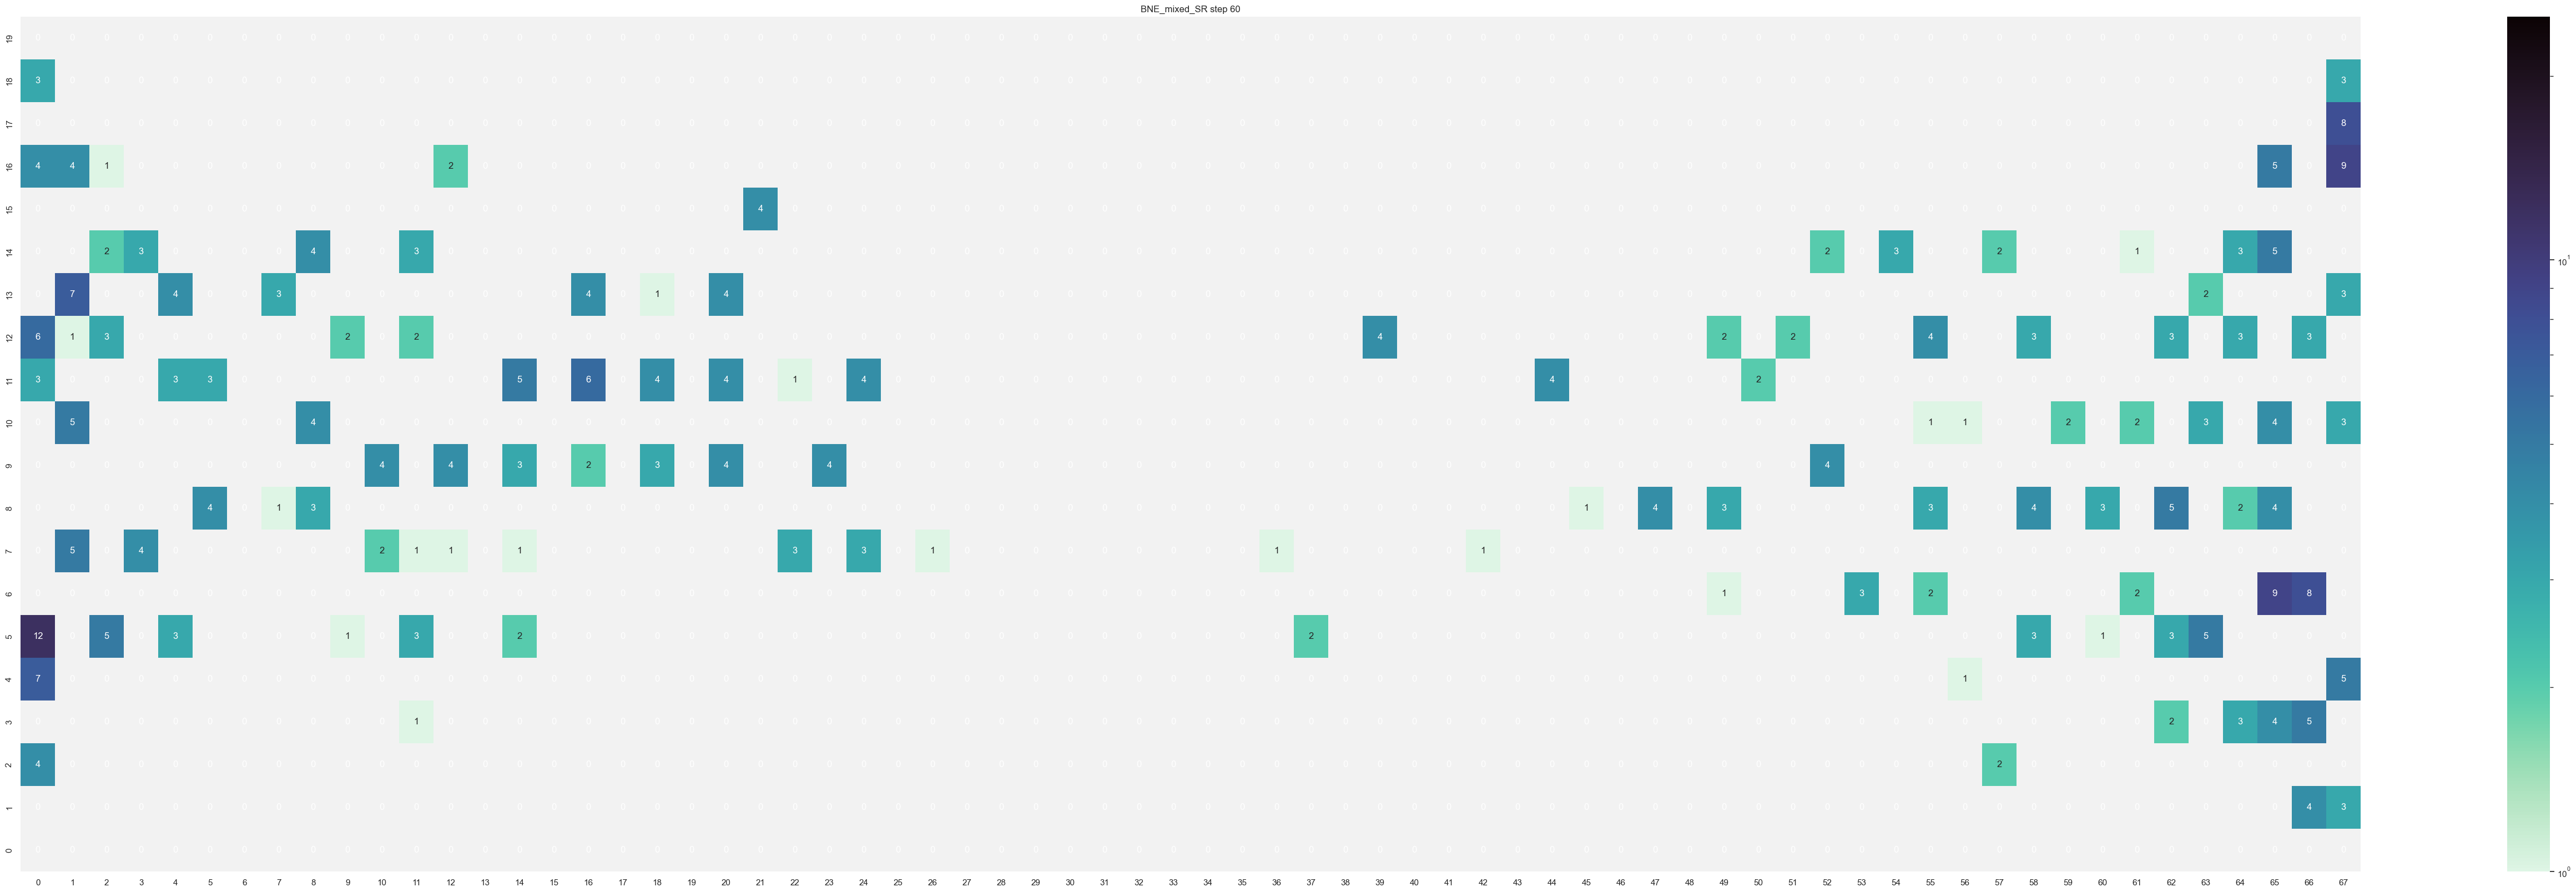

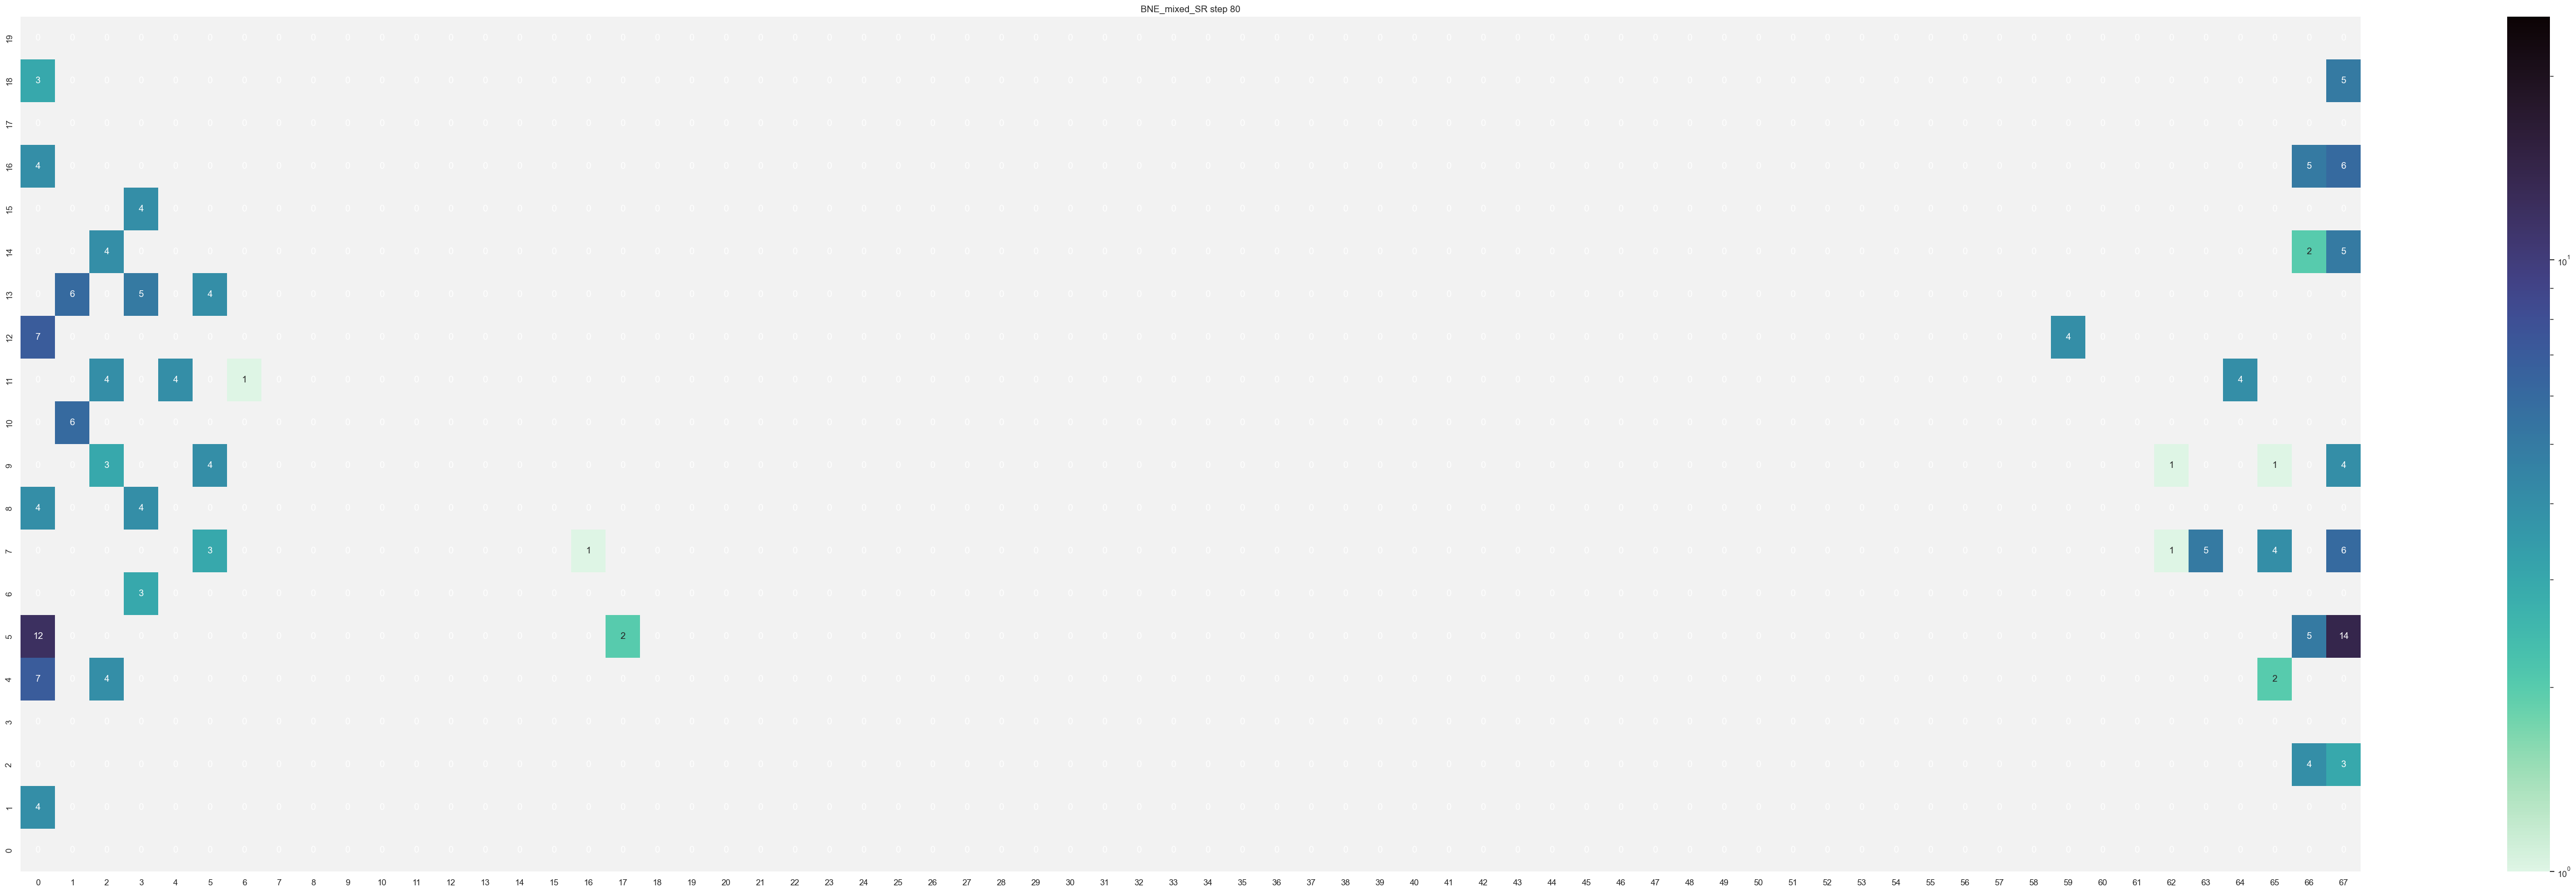

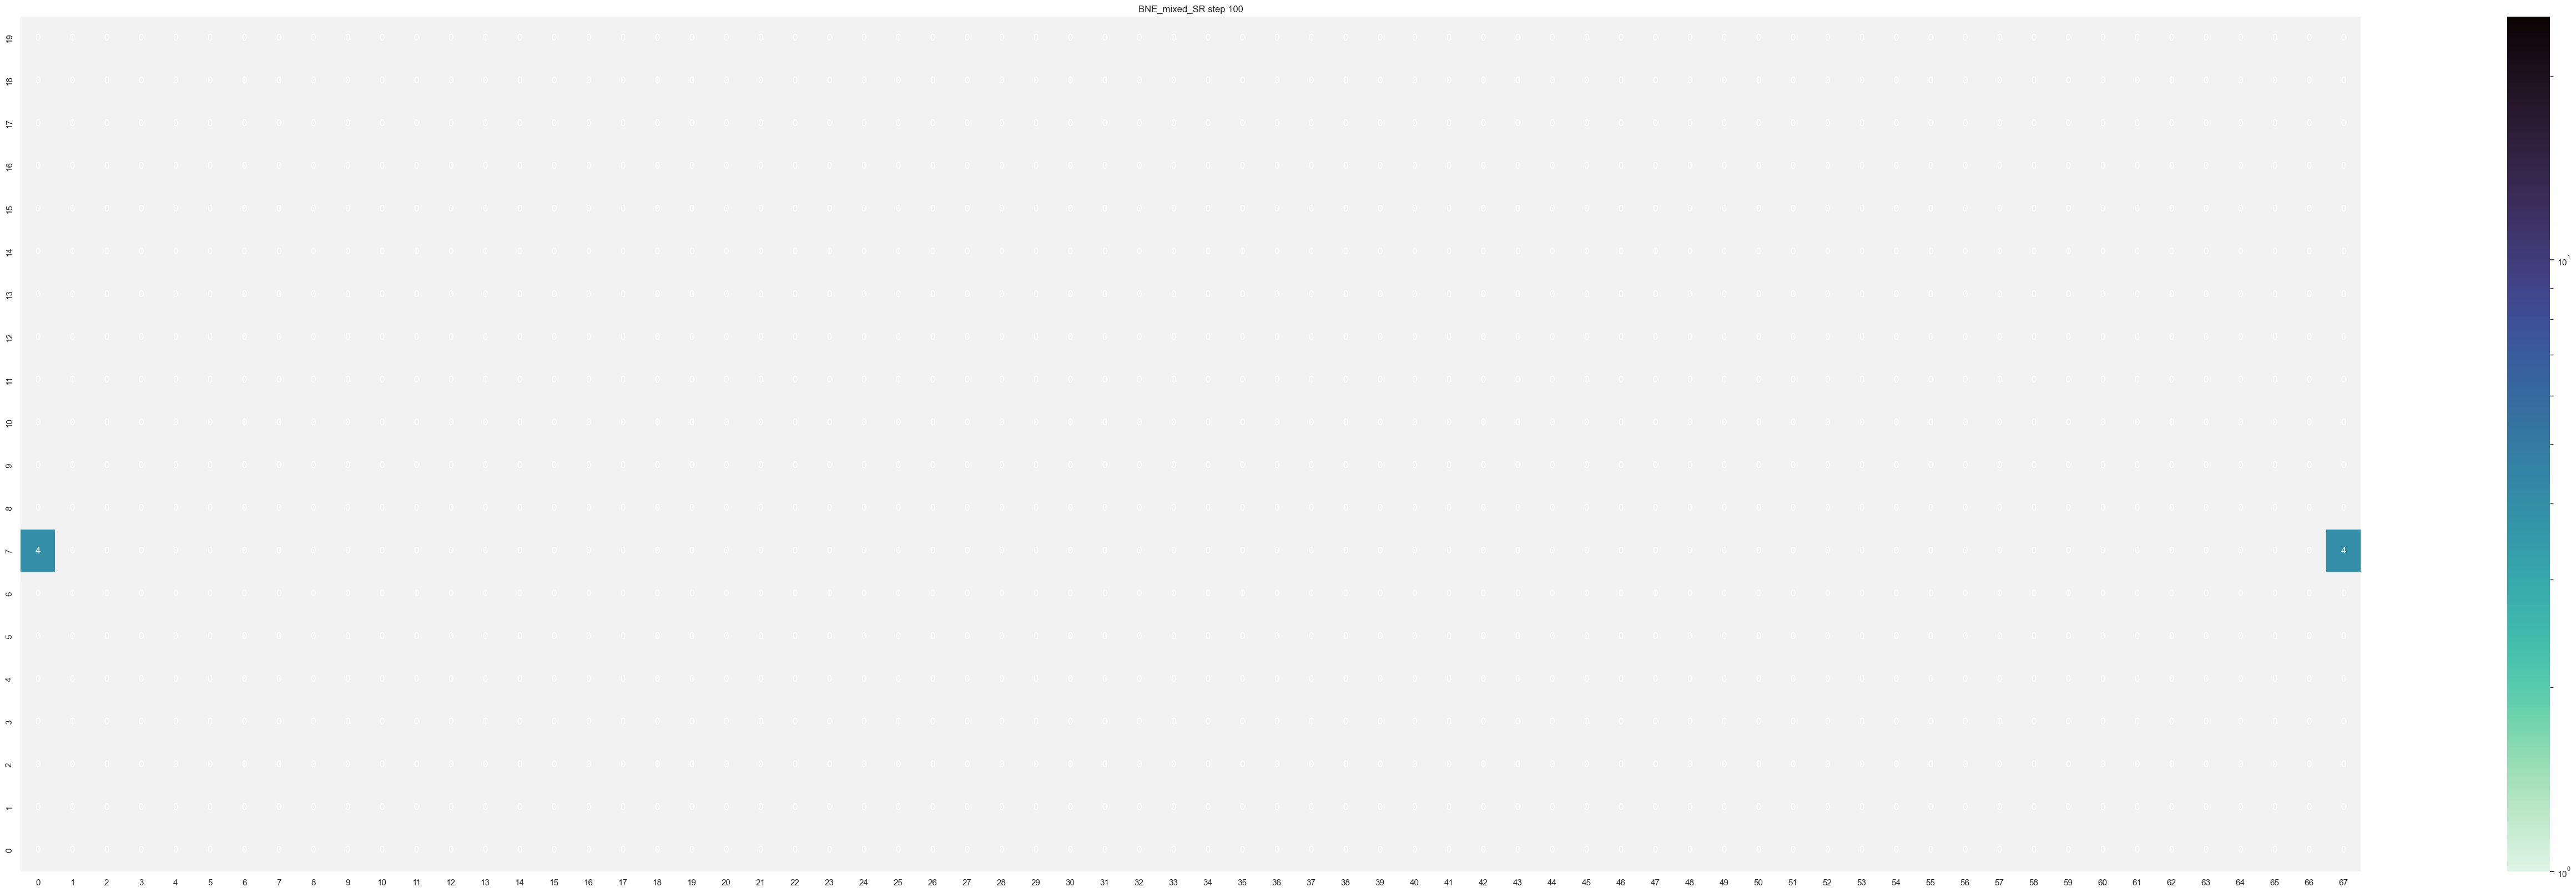

In [10]:
frames(("BNE_mixed_SR", 100))

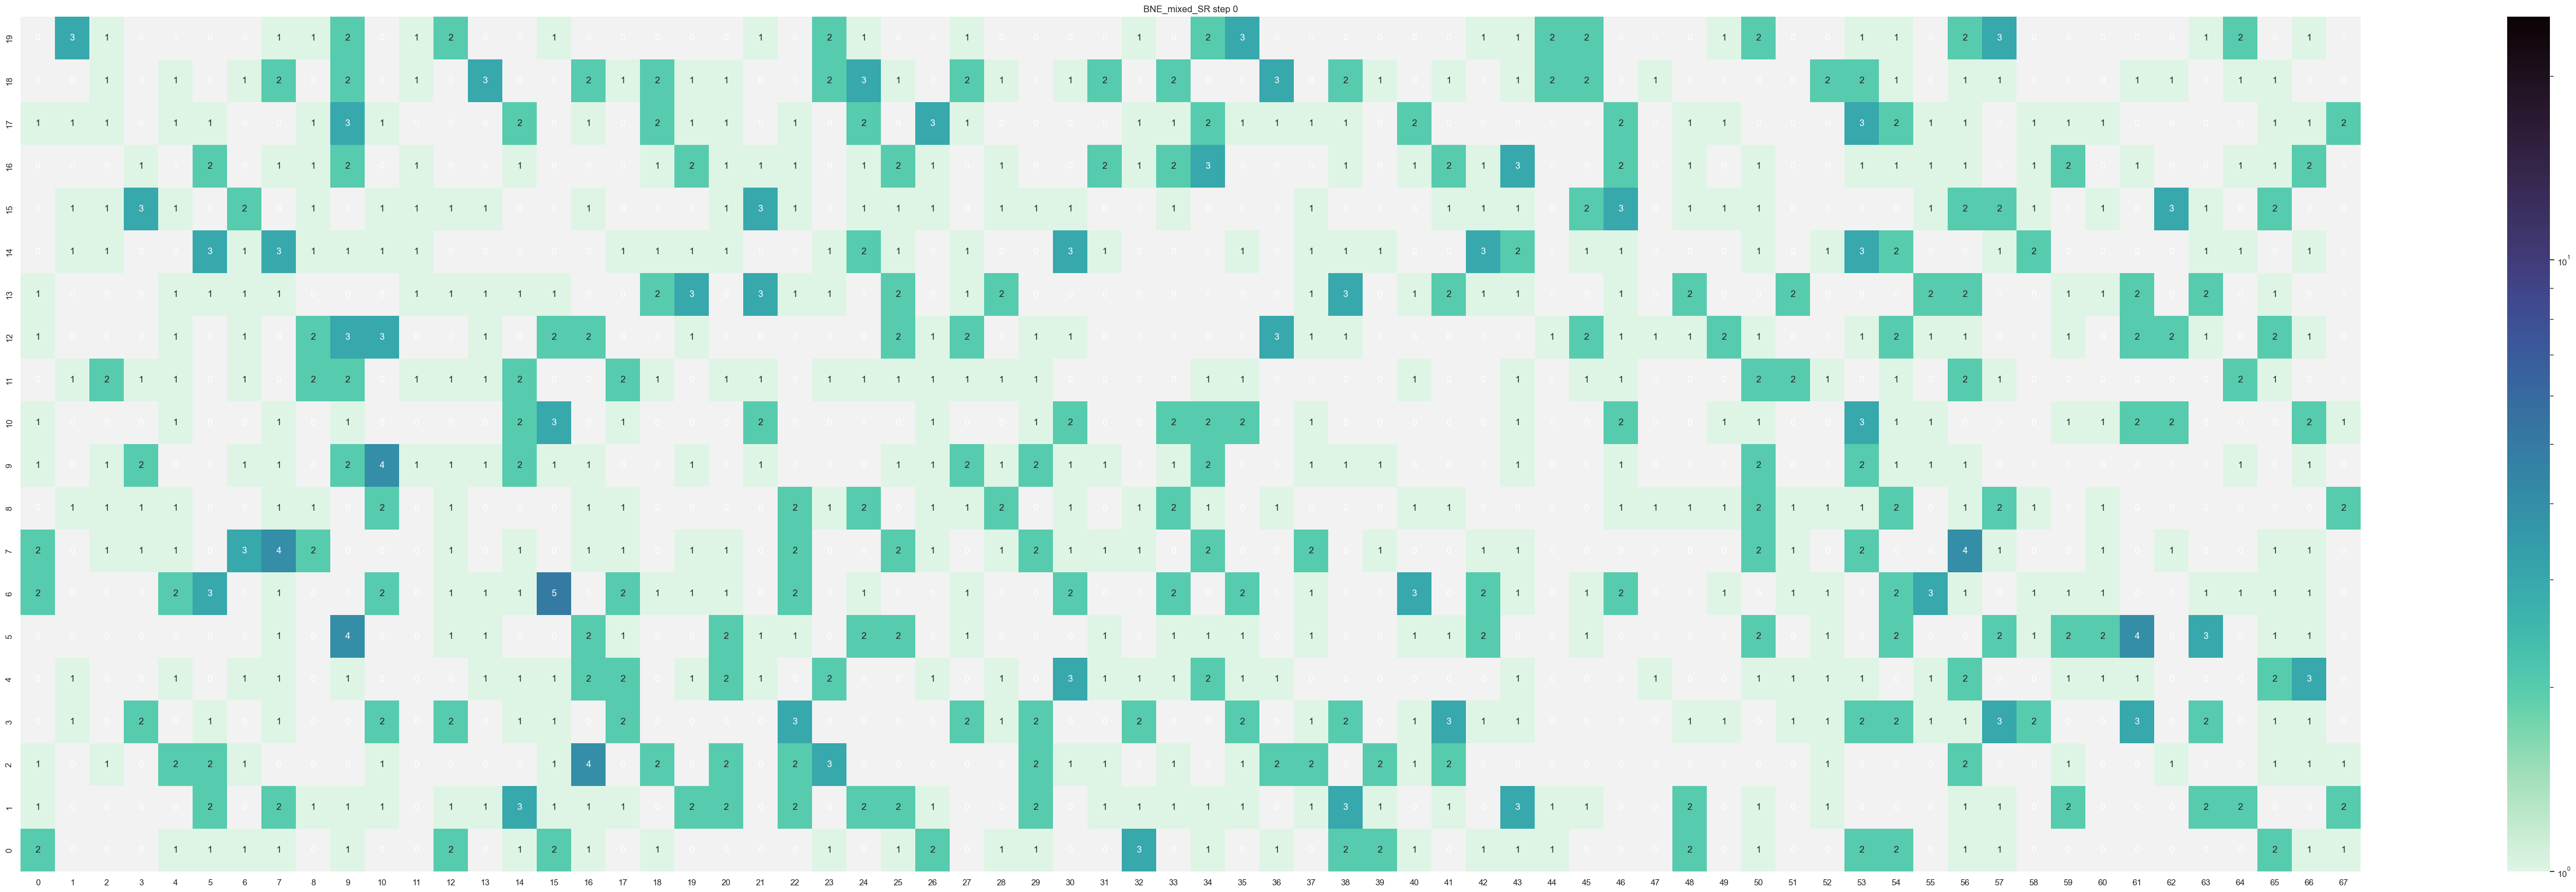

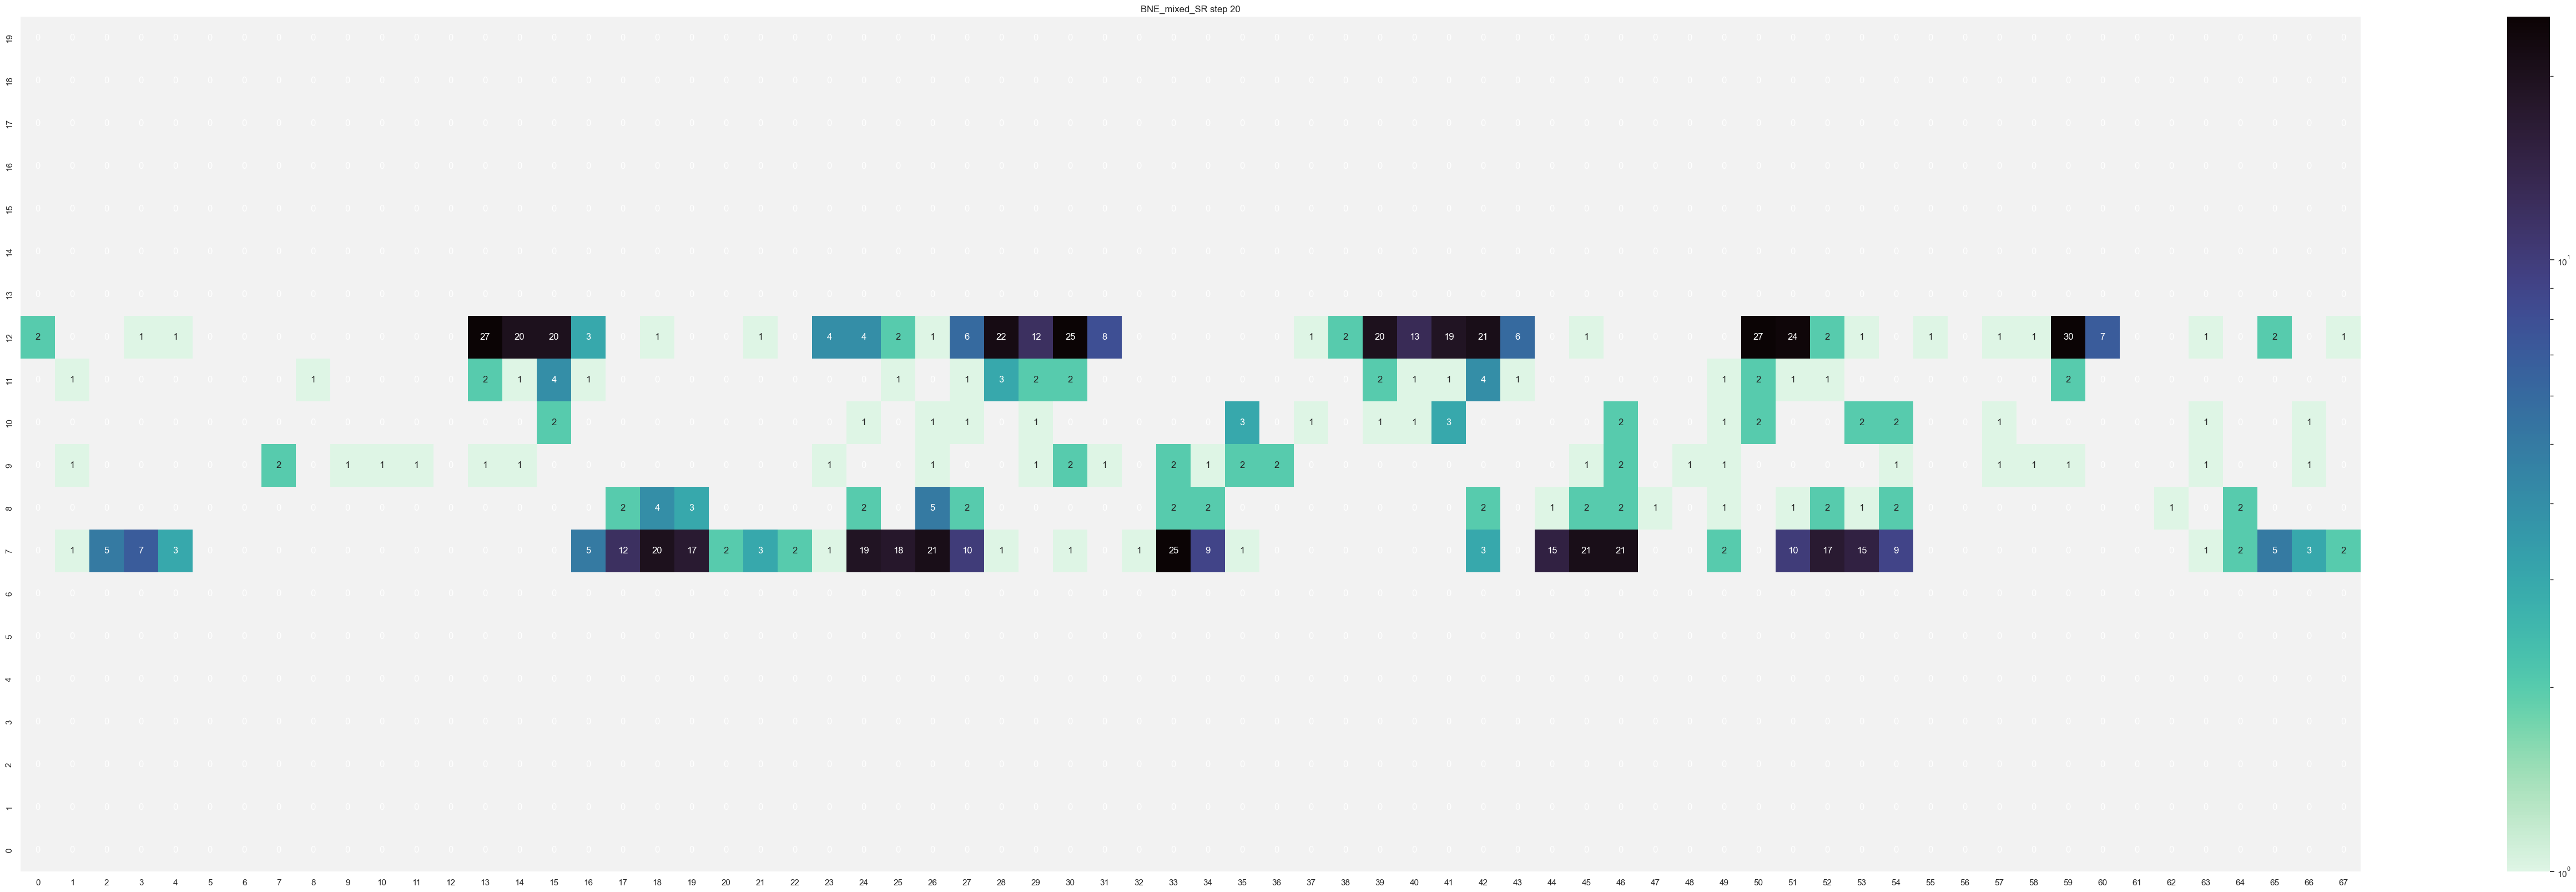

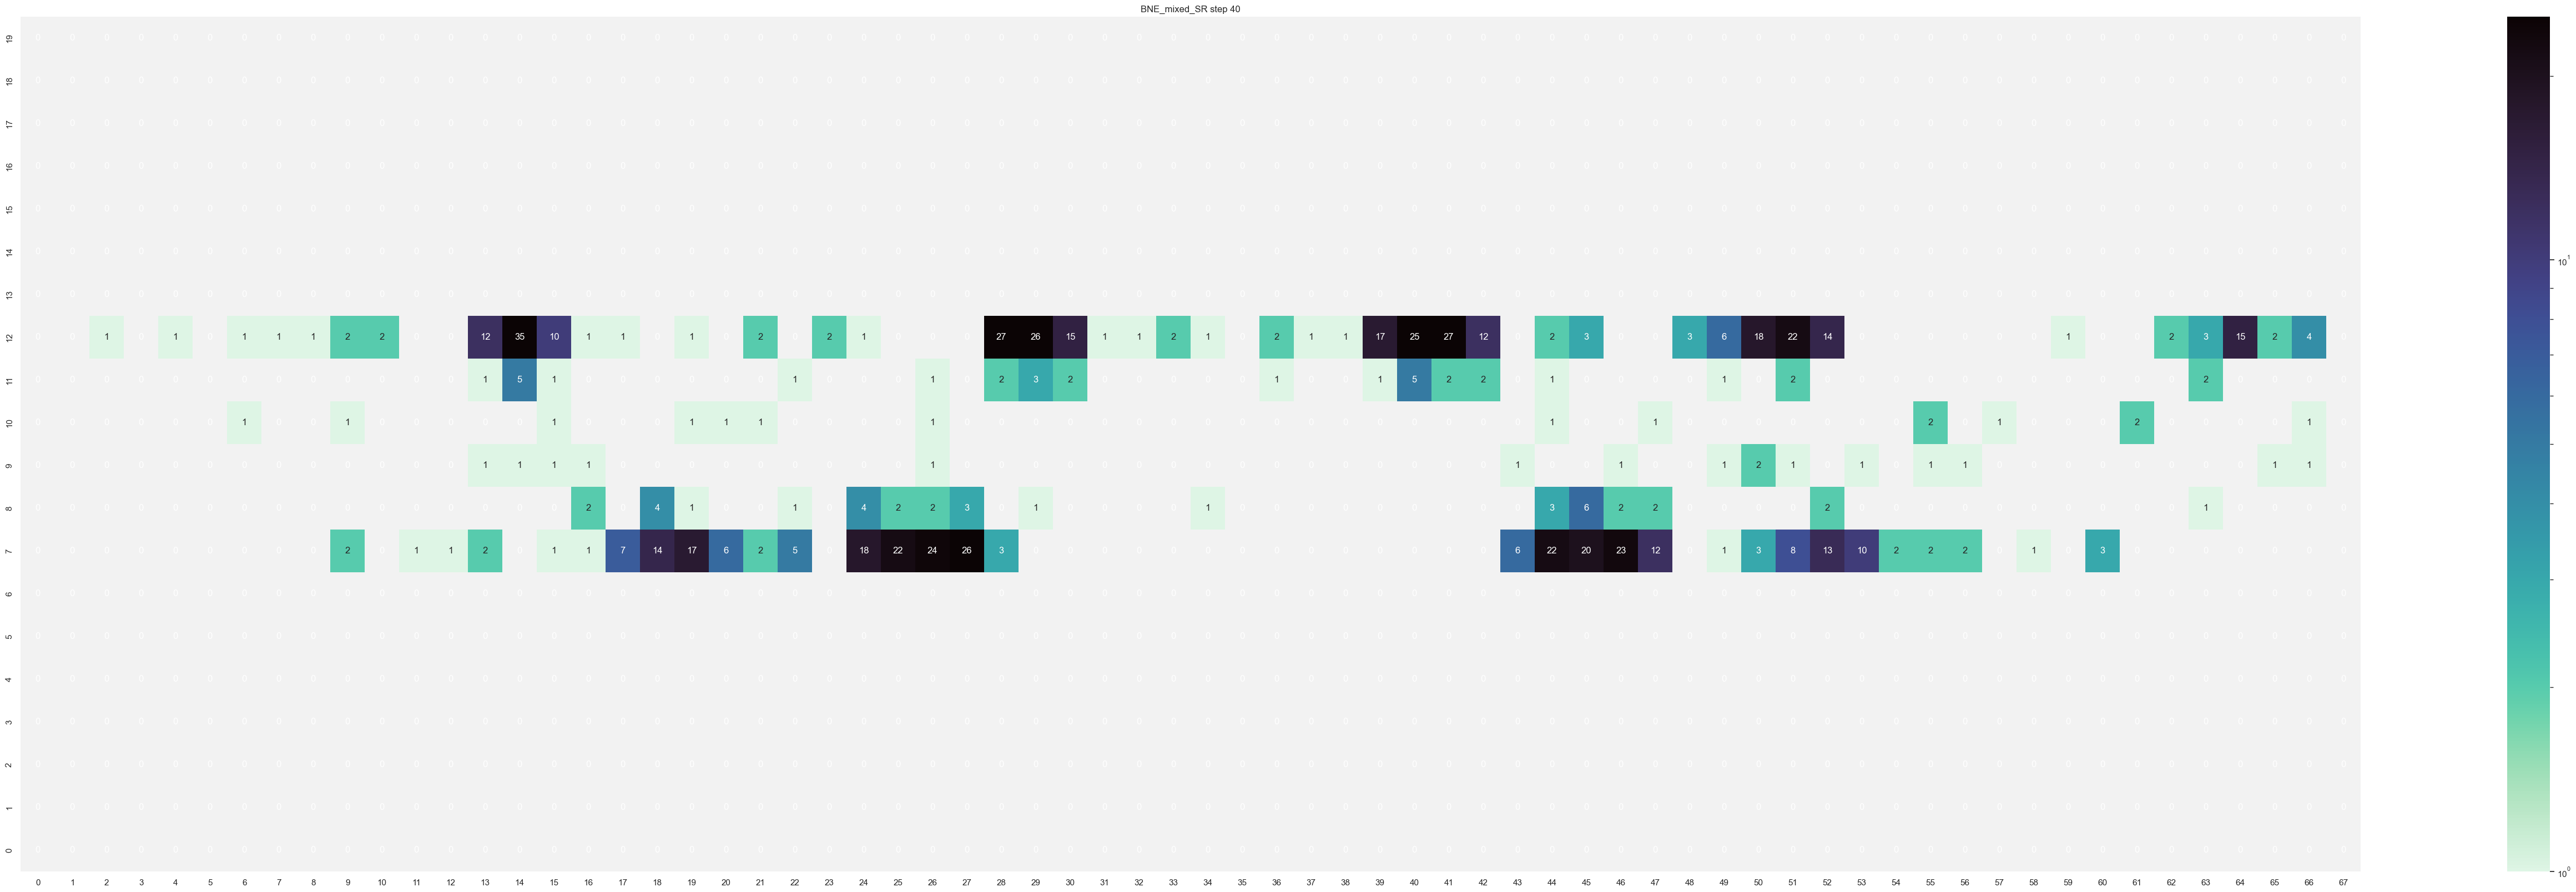

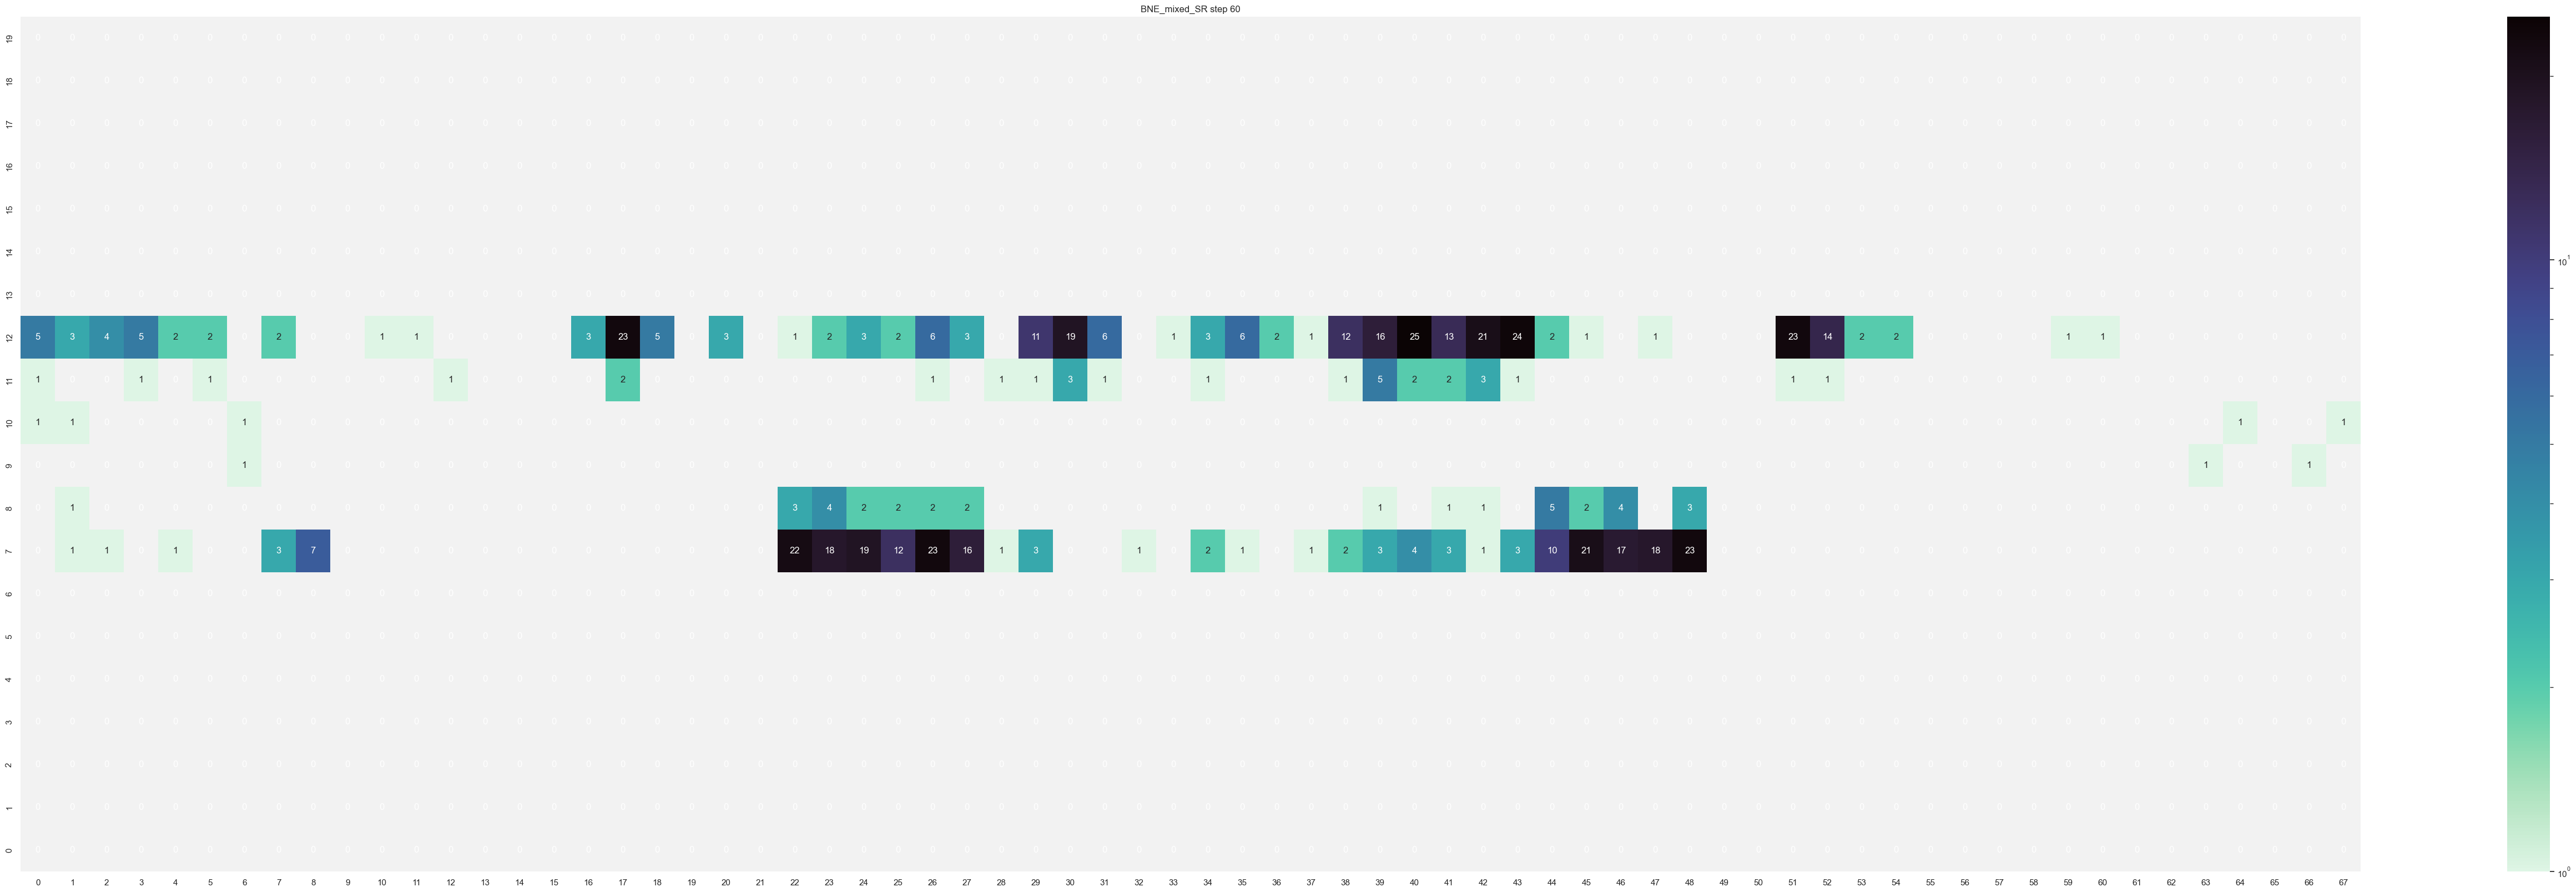

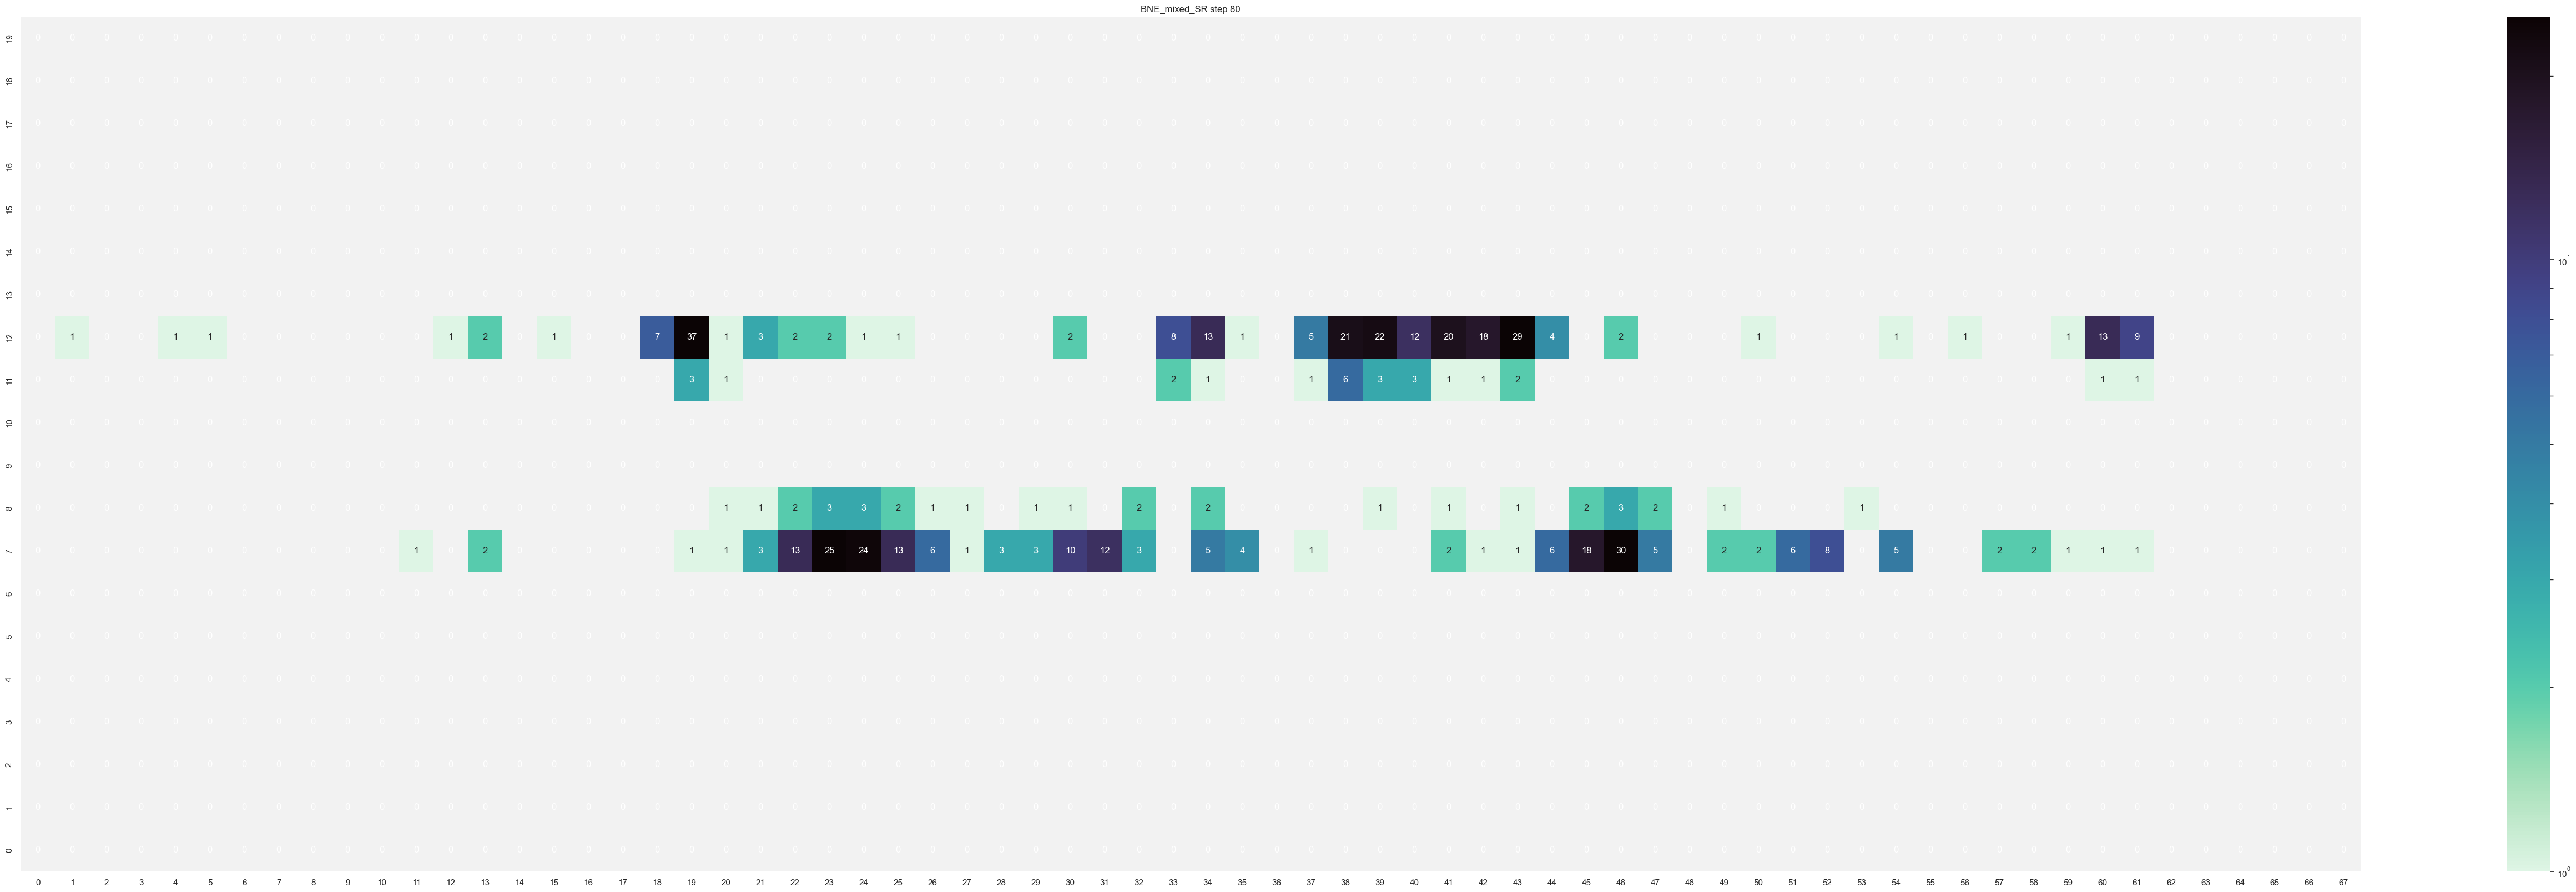

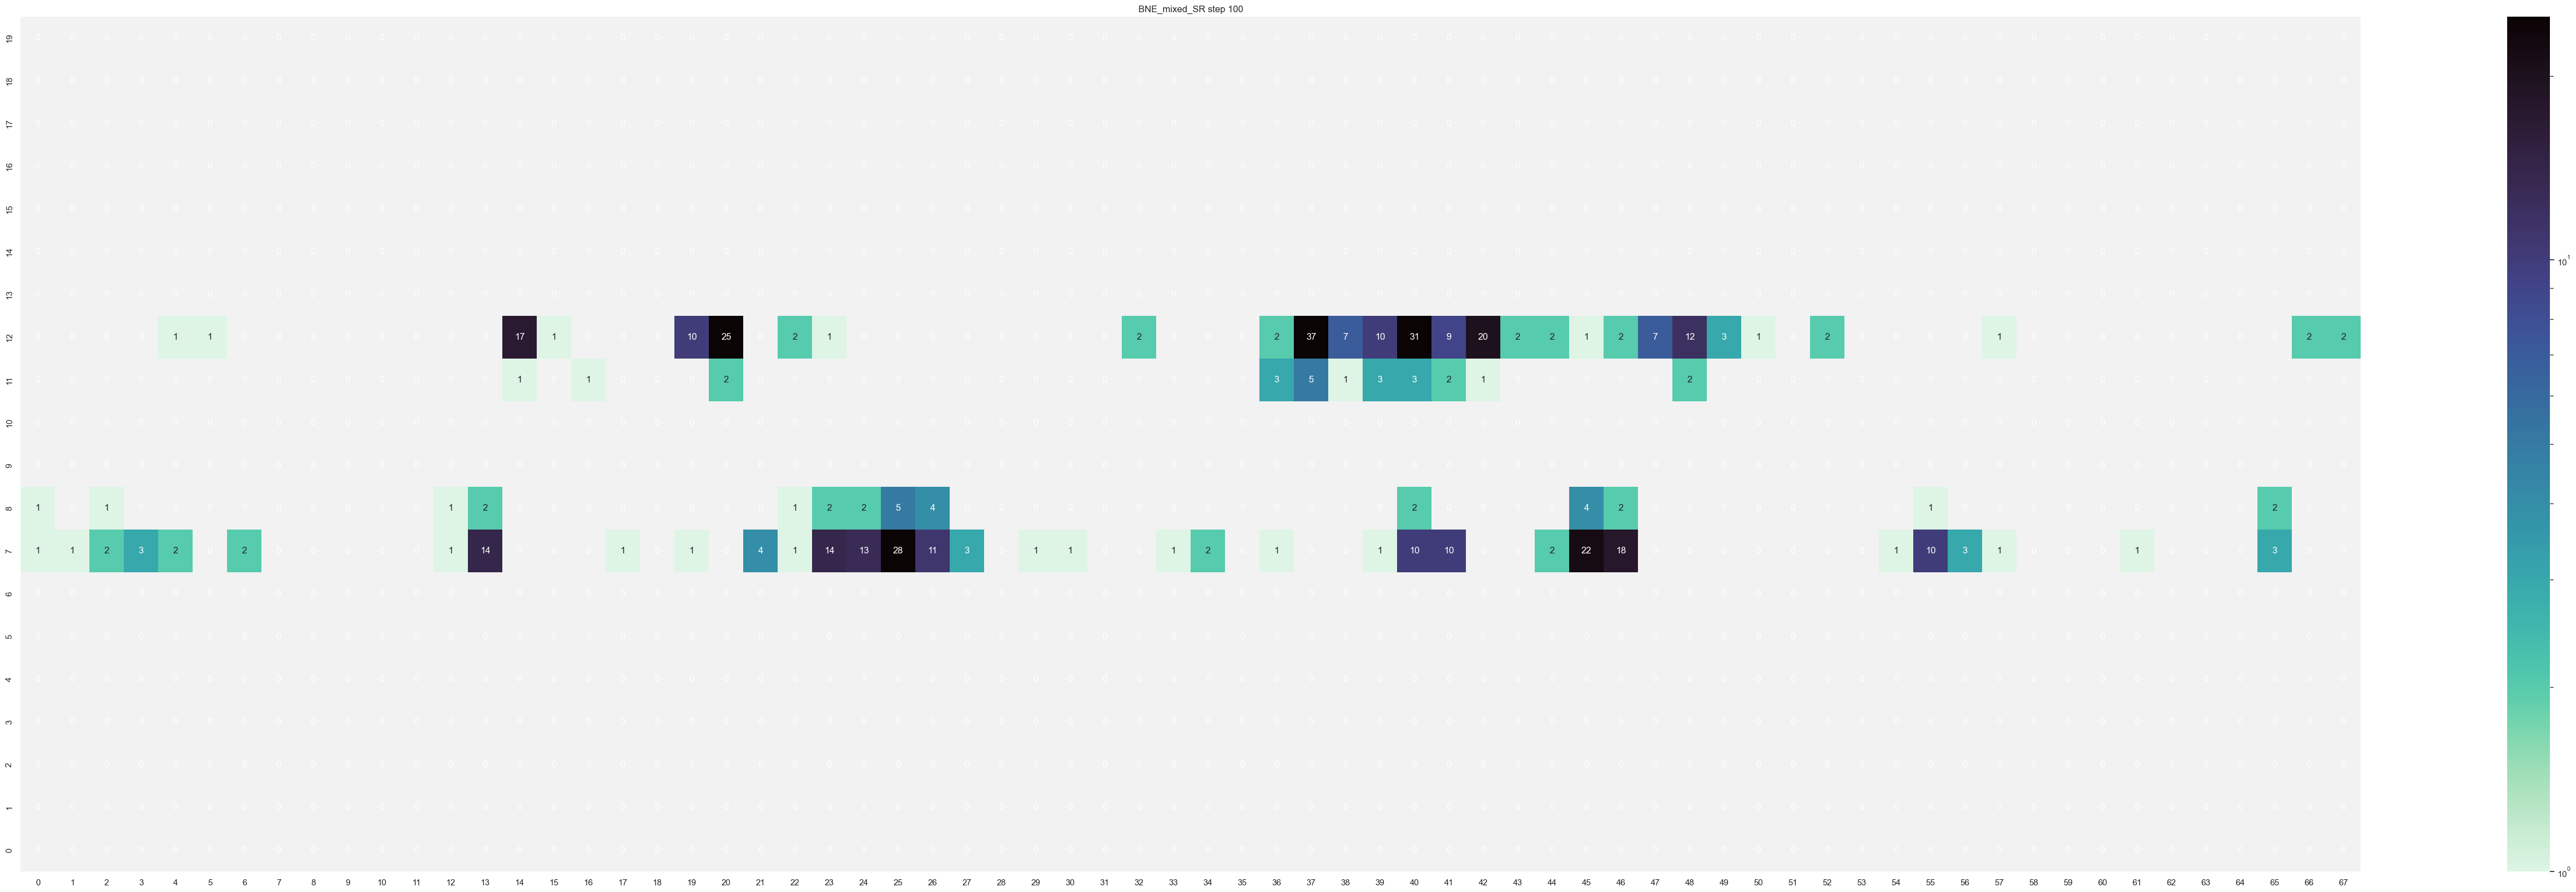

In [11]:
frames(("BNE_mixed_SR", 0))

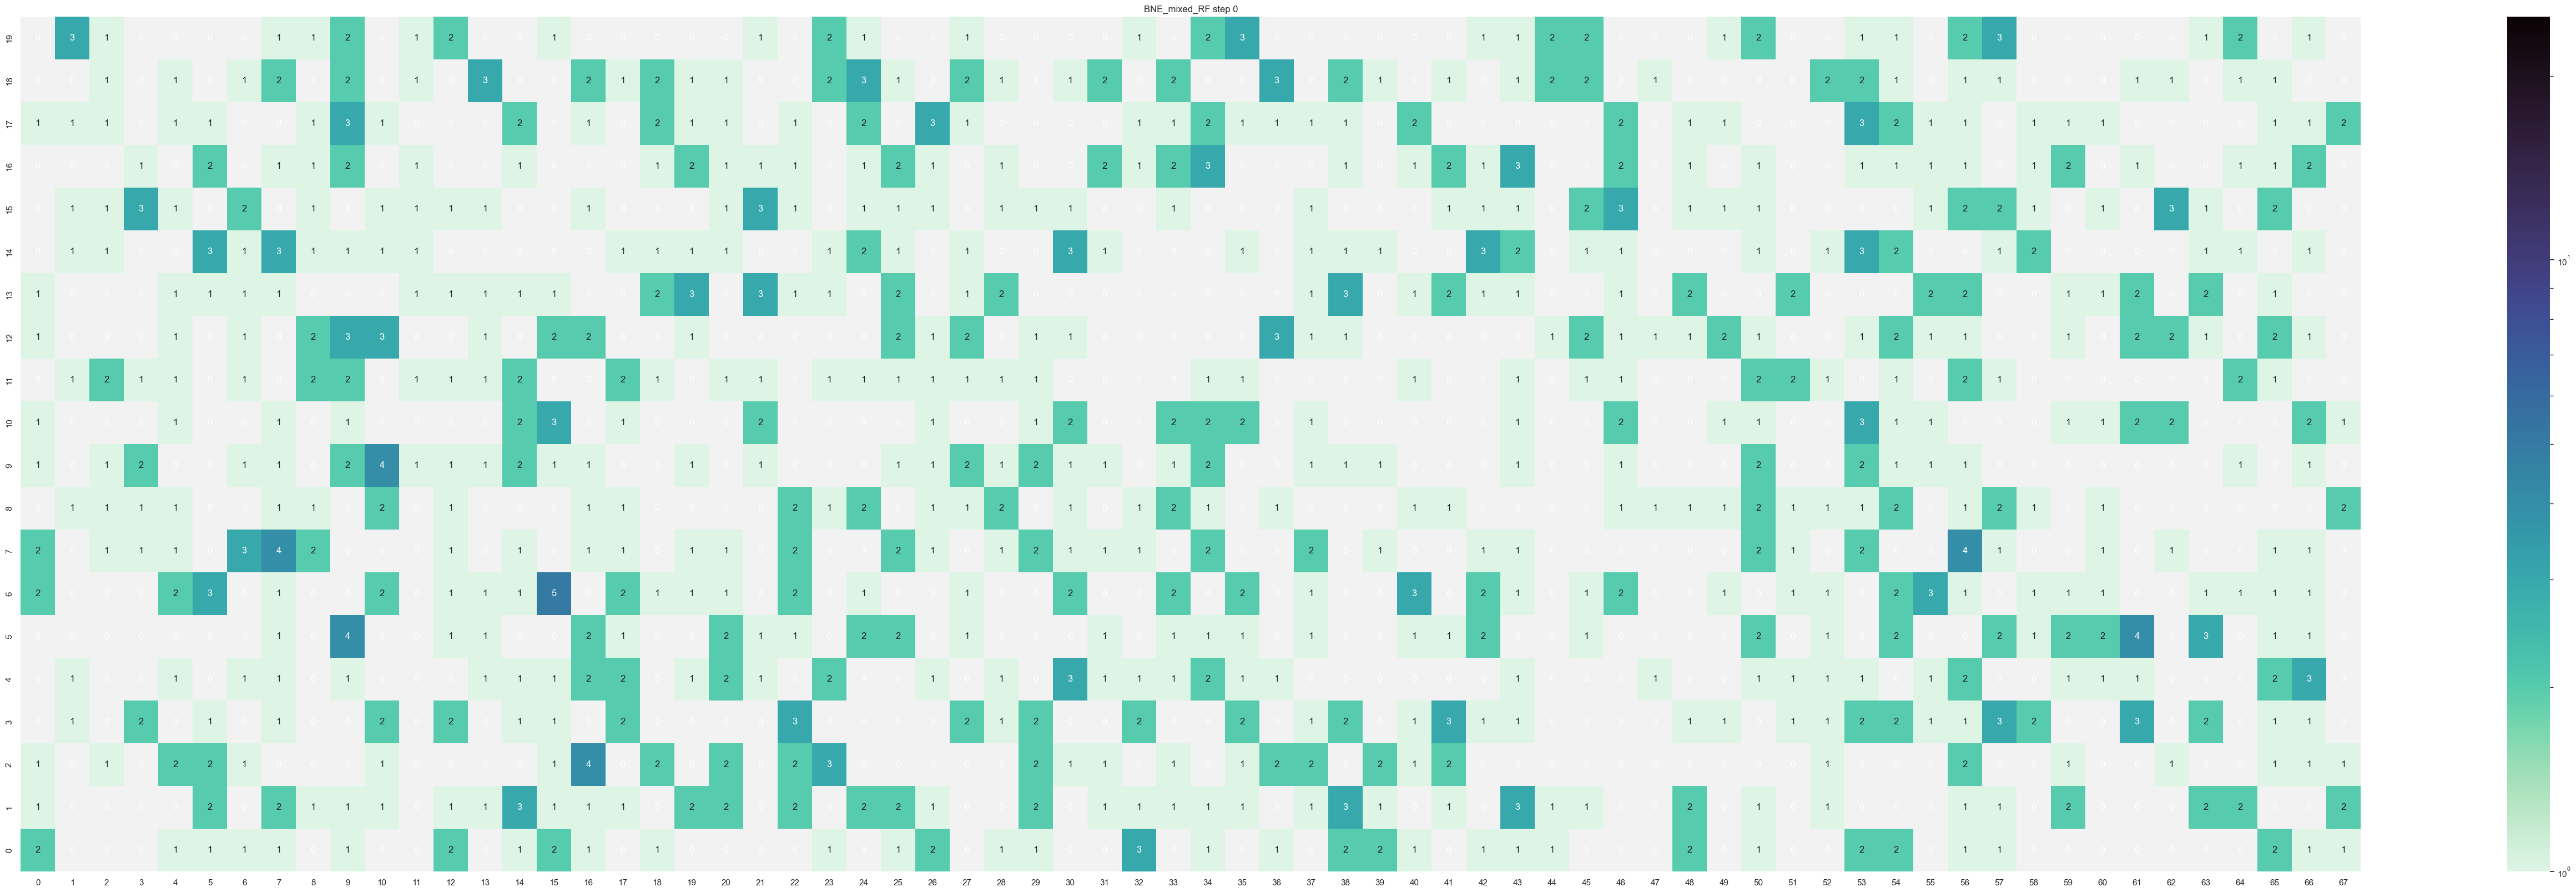

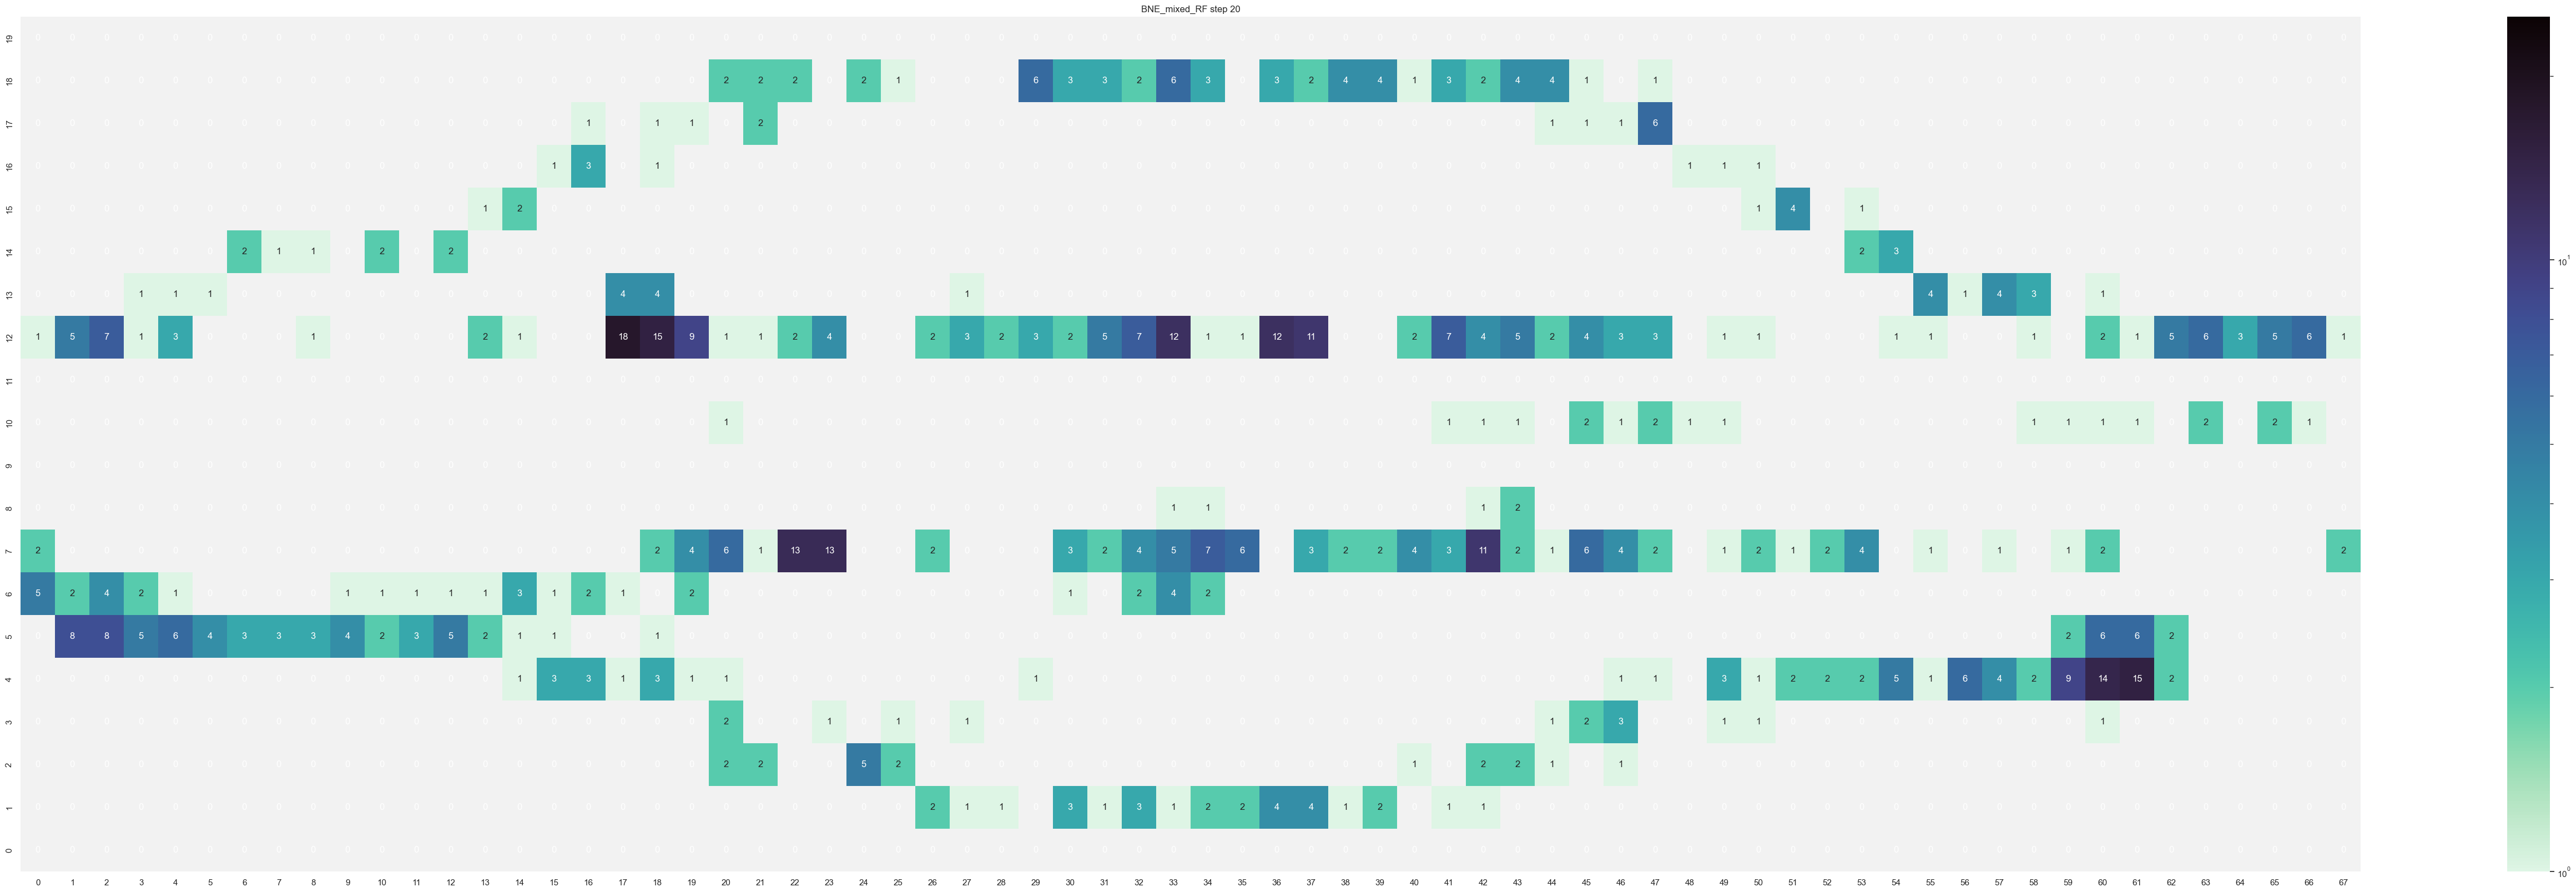

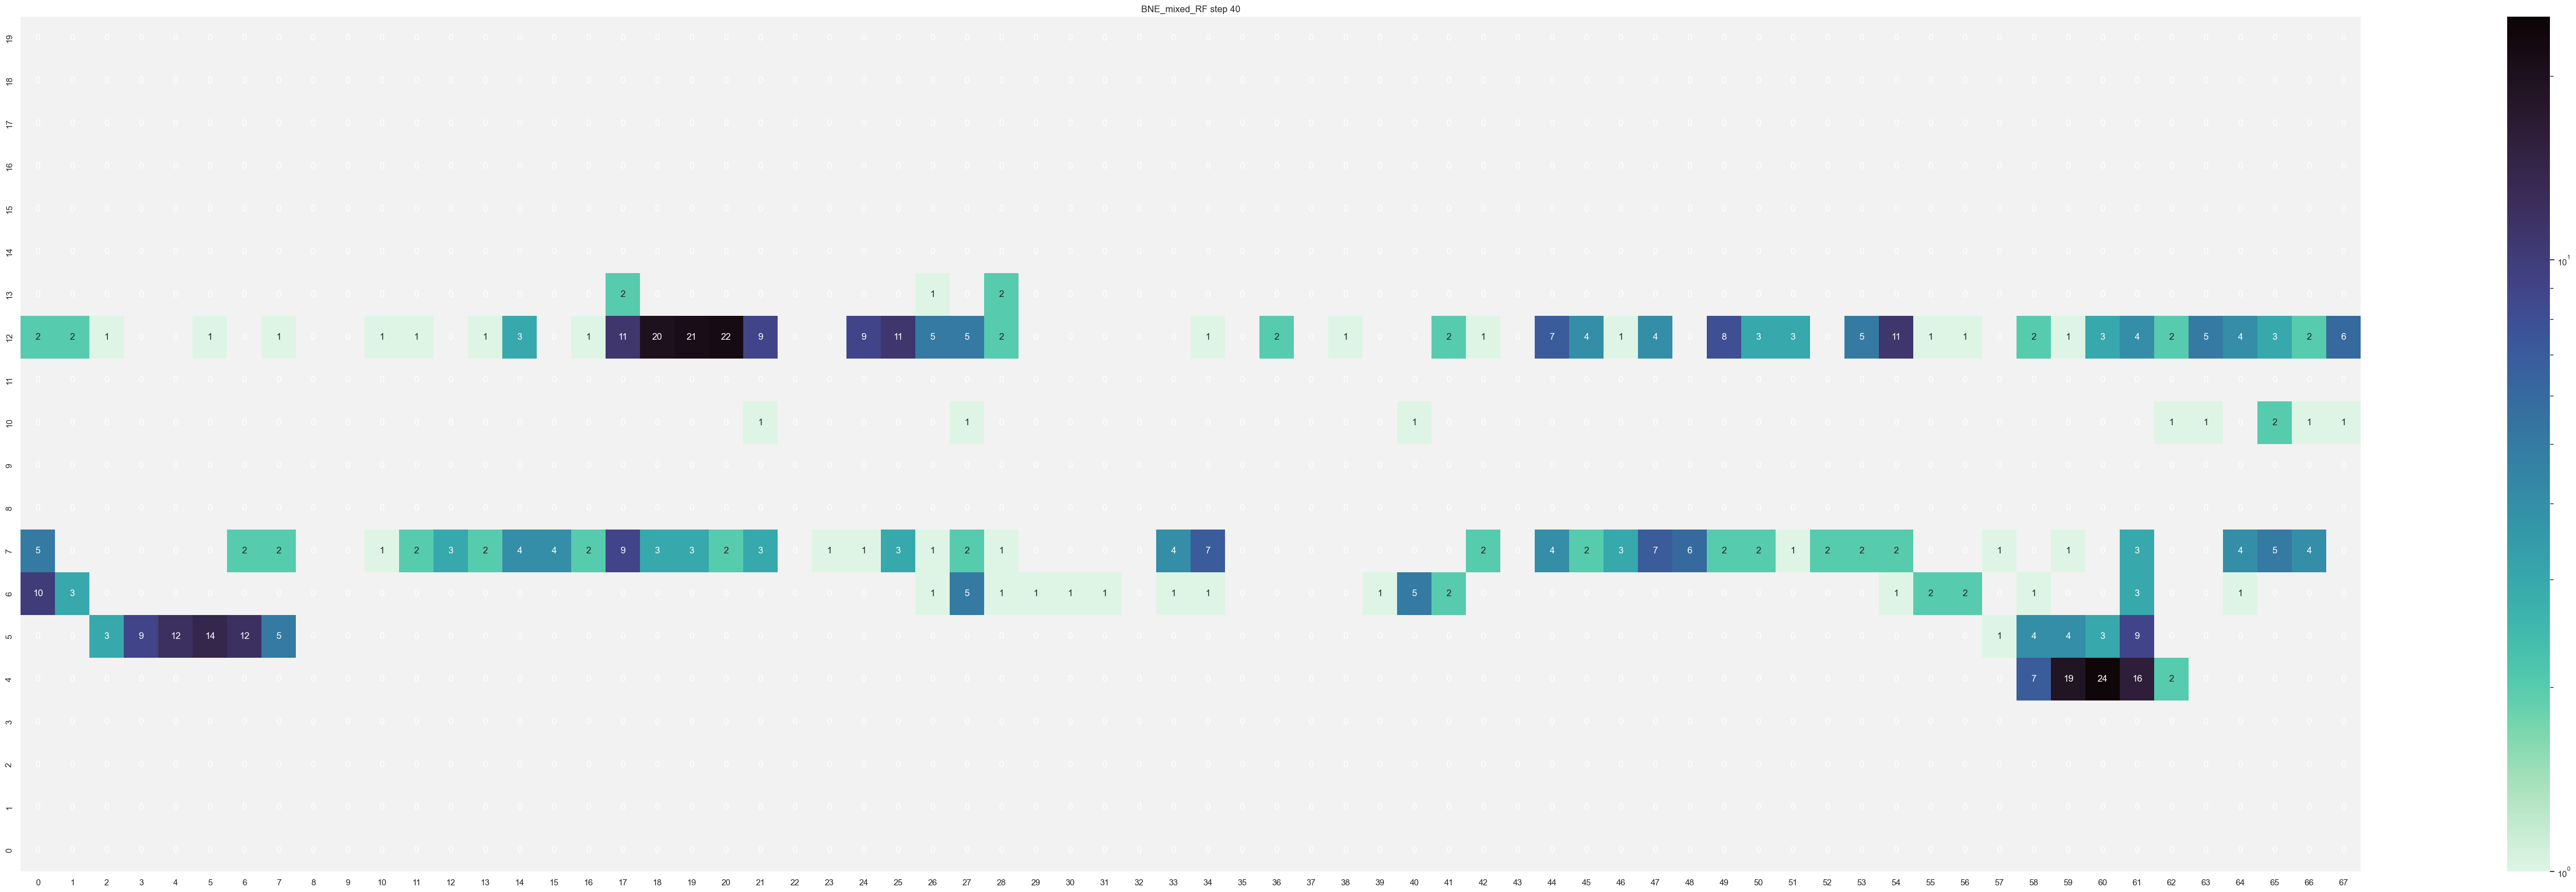

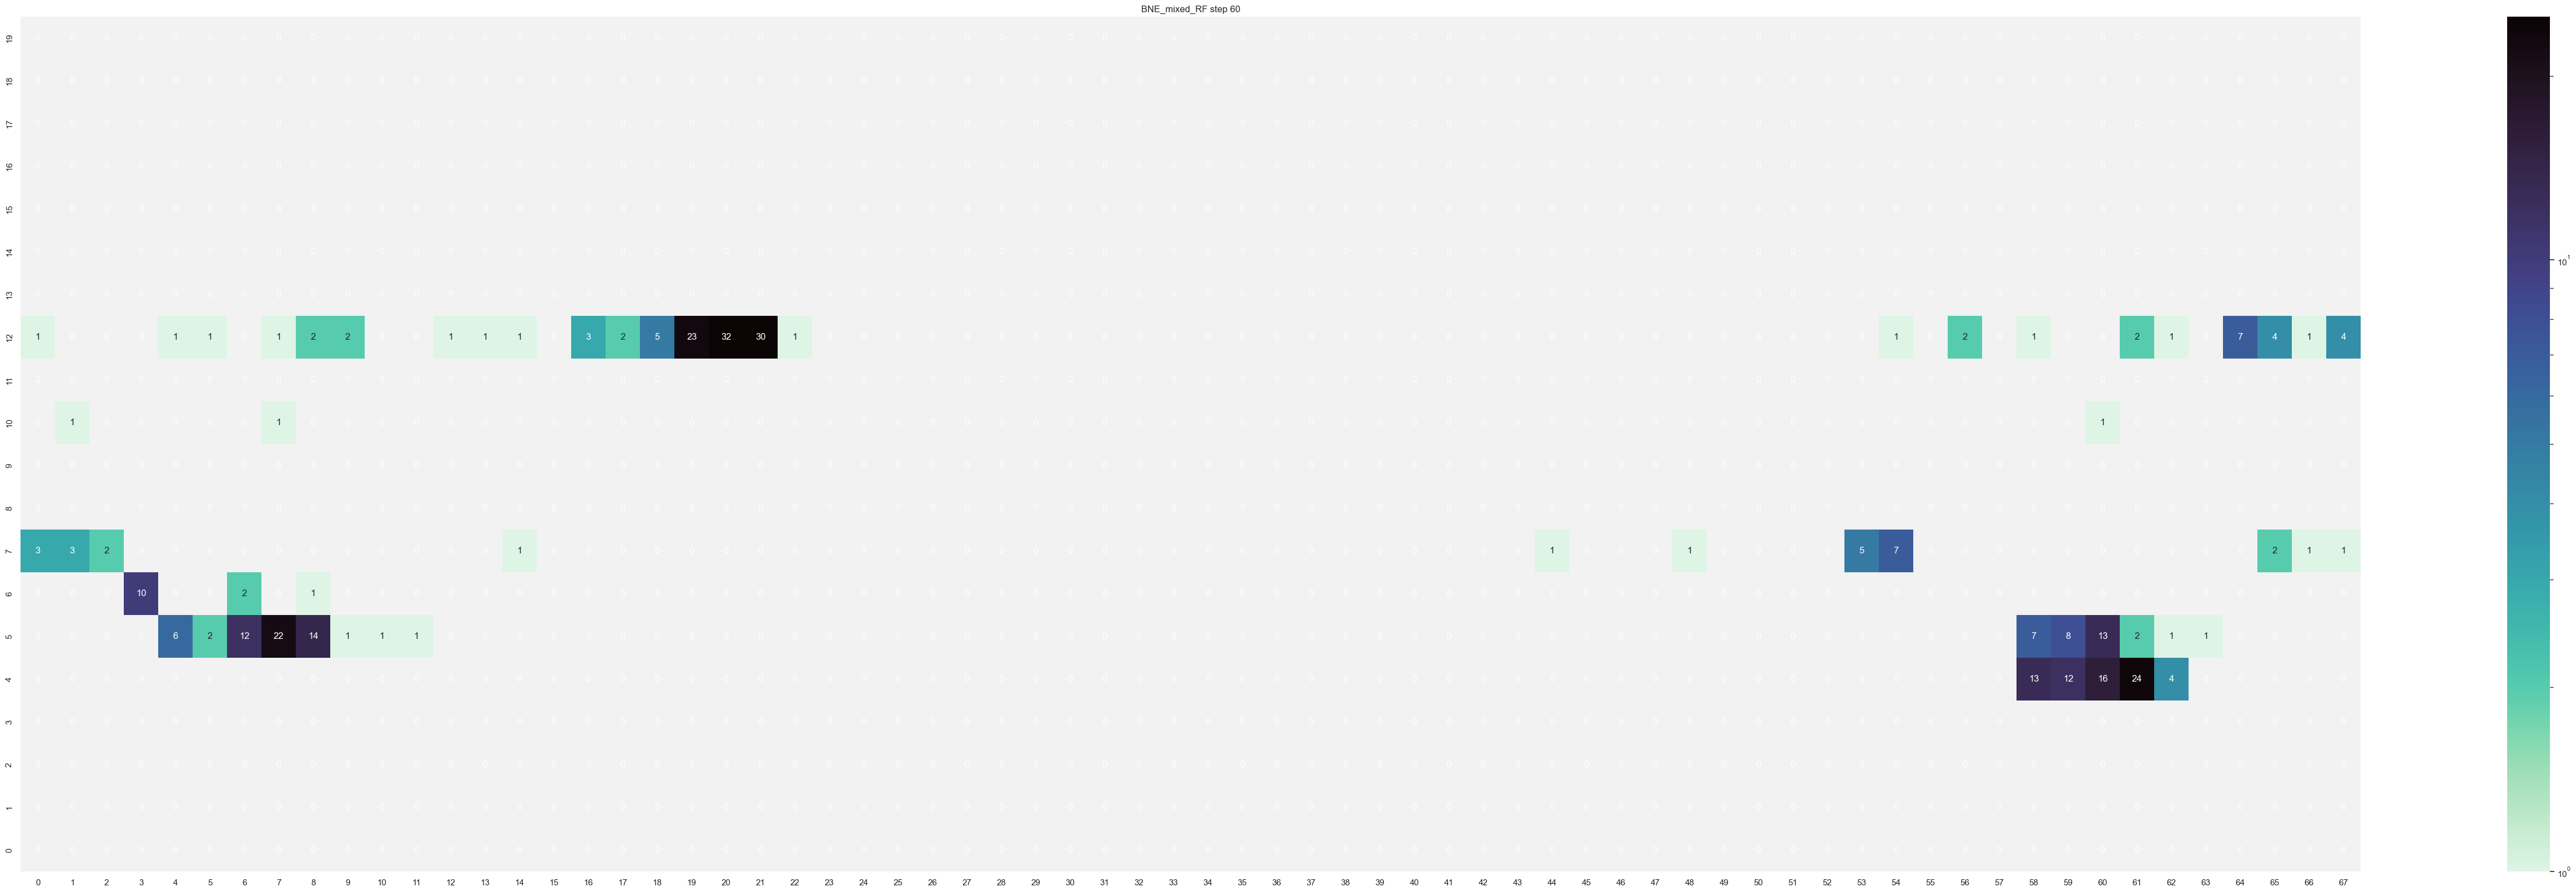

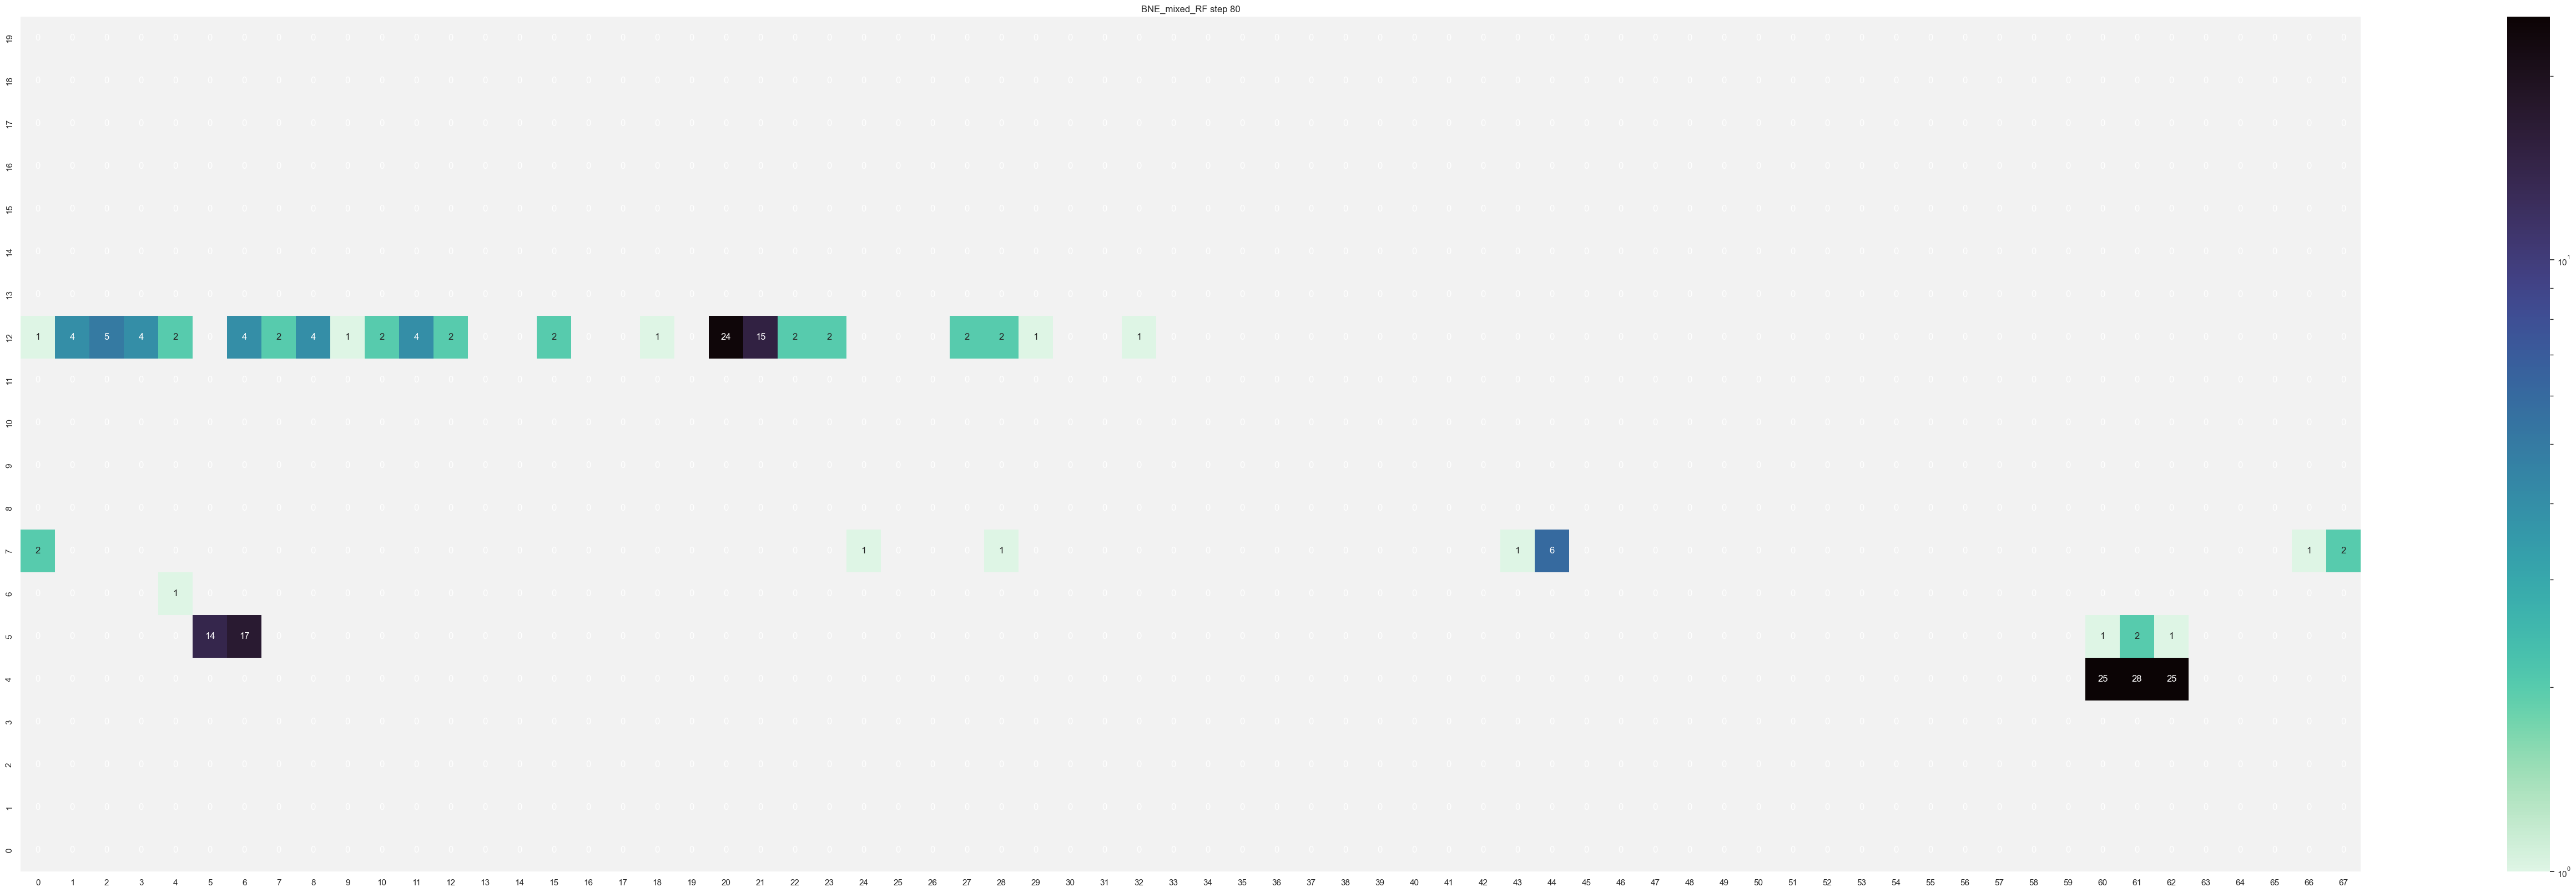

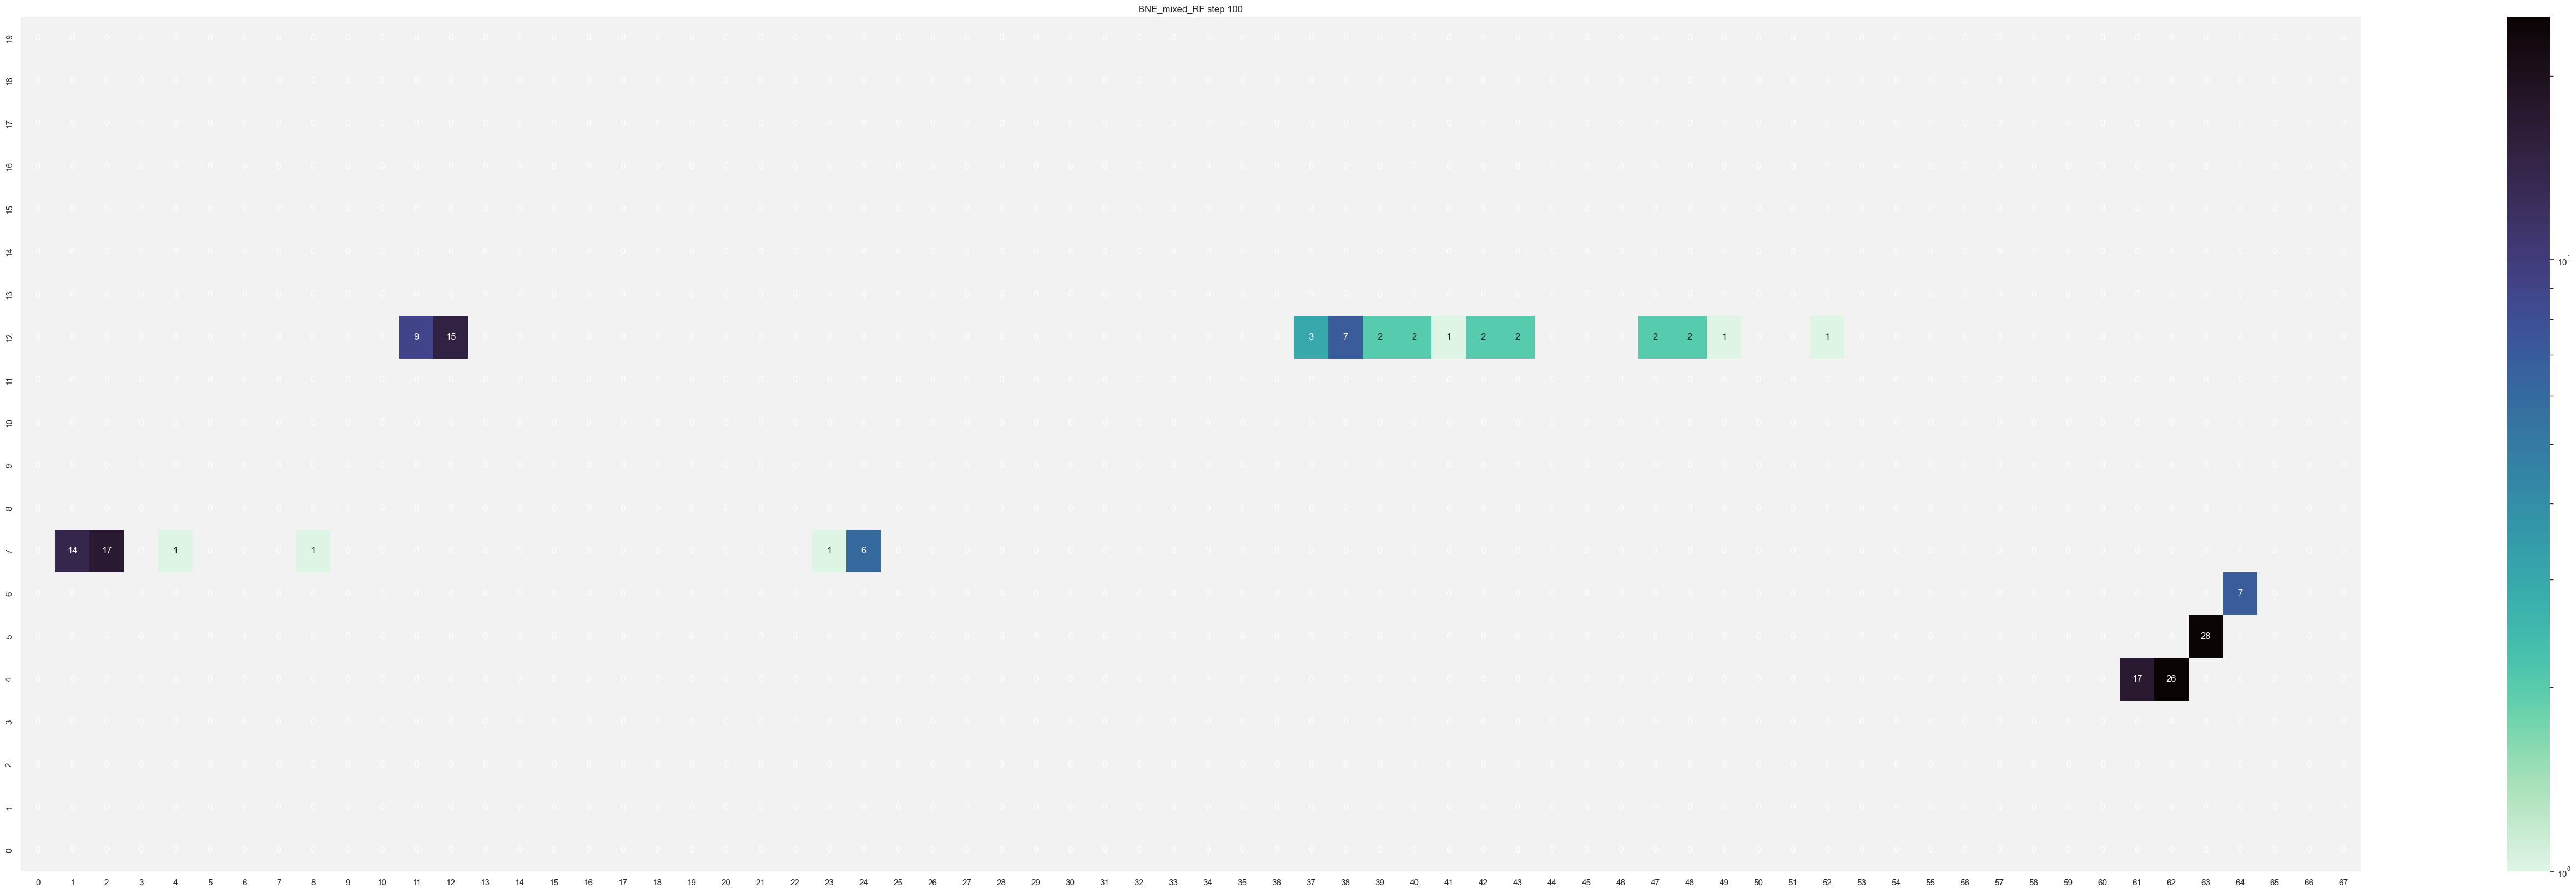

In [12]:
frames(("BNE_mixed_RF", 0))

### Czas ewakuacji w zależności od liczby agentów dla wszystkich metod

In [13]:
Ns = [100, 200, 300, 500, 600, 700, 800]
iters = 50

def simulate_for_N(Ns, model_type, iters = iters):
    all_results = np.zeros(iters*len(Ns))
    for i, N in enumerate(Ns):
        results = batch_run({"n": N , "width": 40, "height": 20, "door_width": 4, "seed": None, "model_type": model_type[0], "p_BNE": model_type[1]}, iters = iters)
        all_results[i*iters:(i+1)*iters] += results.values

    return all_results

In [14]:
Ns_BNE = simulate_for_N(Ns, ("BNE_mixed_SR", 100))

100%|██████████| 50/50 [01:27<00:00,  1.74s/it]


In [15]:
Ns_SR = simulate_for_N(Ns, ("BNE_mixed_SR", 0))

100%|██████████| 50/50 [02:03<00:00,  2.46s/it]


In [16]:
Ns_RF = simulate_for_N(Ns, ("BNE_mixed_RF", 0))

100%|██████████| 50/50 [06:08<00:00,  7.37s/it]


In [21]:
Ns_df = pd.DataFrame(
    {   "model_type": np.repeat(["BNE", "RF", "SR"], iters*len(Ns)),
        "n": np.tile(np.repeat(Ns, iters),3),
        "exit_time": np.concatenate((Ns_BNE, Ns_RF, Ns_SR))
    })
Ns_df

,model_type,n,exit_time
0,BNE,100,40.0
1,BNE,100,40.0
2,BNE,100,40.0
3,BNE,100,40.0
4,BNE,100,41.0
...,...,...,...
1045,SR,800,173.0
1046,SR,800,153.0
1047,SR,800,159.0
1048,SR,800,149.0


Text(0.5, 0, 'n (liczba agentów)')

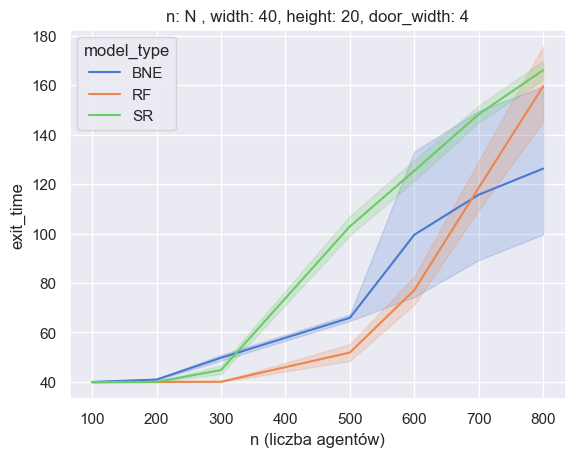

In [22]:
sns.set_theme()
sns.lineplot(data = Ns_df, x = "n", y="exit_time", hue = "model_type", palette="muted" )
plt.title("n: N , width: 40, height: 20, door_width: 4")
plt.xlabel("n (liczba agentów)")

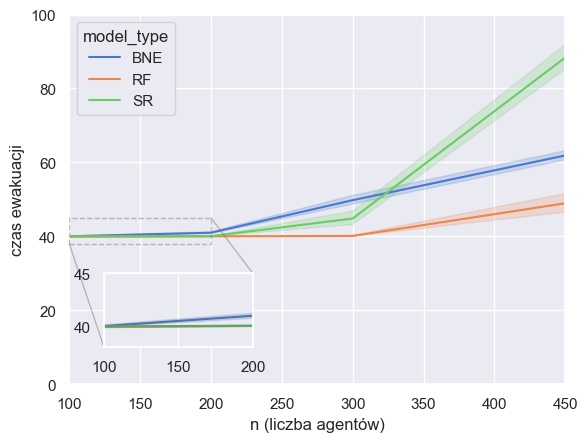

In [23]:
fig, ax = plt.subplots()
sns.lineplot(data = Ns_df, x = "n", y="exit_time", hue = "model_type", palette="muted",ax=ax)
plt.xlabel("n (liczba agentów)")
plt.ylabel("czas ewakuacji")
plt.xlim(100,450)
plt.ylim(0,100)


zm = ax.inset_axes([0.07, 0.1, 0.3, 0.2], xlim = (100,200), ylim = (38, 45))
sns.lineplot(data=Ns_df, x='n', y='exit_time', hue= "model_type", ax =zm, legend=False)
ax.indicate_inset_zoom(zm, edgecolor = 'gray', linestyle = '--', alpha = 0.5)
zm.set(xlabel=None)
zm.set(ylabel=None)
plt.show()